In [4]:
pip install lazypredict

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: lazypredict in c:\users\мария\appdata\local\programs\python\python311\lib\site-packages (0.2.13)




[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# GEOSPHERE AUSTRIA DATA

## Load the data

In [5]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lazypredict
from lazypredict.Supervised import LazyRegressor

### Stations data

In [6]:
metadata_url = "https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-1d/metadata"

response = requests.get(metadata_url)
if response.status_code == 200:
    stations = response.json()['stations']
    print("Sucessfully fetched metadata!")
else:
    print(f"Failed to fetch metadata. Status code: {response.status_code}")

Sucessfully fetched metadata!


In [7]:
# Convert to Pandas DataFrame
stations_df = pd.DataFrame(stations)

# Display the first few rows
print(stations_df.head())

       type  id  group_id              name             state   lat   lon  \
0  COMBINED   1       NaN            Aflenz        Steiermark 47.55 15.24   
1  COMBINED   2       NaN  Aigen im Ennstal        Steiermark 47.53 14.14   
2  COMBINED   3       NaN       Allentsteig  Niederösterreich 48.69 15.37   
3  COMBINED   4       NaN         Amstetten  Niederösterreich 48.11 14.89   
4  COMBINED   5       NaN        Bad Aussee        Steiermark 47.61 13.76   

   altitude                 valid_from                   valid_to  \
0    783.20  1983-05-01T00:00:00+00:00  2100-12-31T00:00:00+00:00   
1    641.00  1939-03-01T00:00:00+00:00  2100-12-31T00:00:00+00:00   
2    598.80  1983-10-01T00:00:00+00:00  2100-12-31T00:00:00+00:00   
3    266.00  1936-01-01T00:00:00+00:00  2100-12-31T00:00:00+00:00   
4    743.10  1983-09-01T00:00:00+00:00  2100-12-31T00:00:00+00:00   

   has_sunshine  has_global_radiation  is_active  
0          True                  True       True  
1          True     

In [19]:
stations_df.head()

,type,id,group_id,name,state,lat,lon,altitude,valid_from,valid_to,has_sunshine,has_global_radiation,is_active
0,COMBINED,1,NaN,Aflenz,Steiermark,47.55,15.24,783.20,1983-05-01 00:00:00+00:00,2100-12-31 00:00:00+00:00,True,True,True
1,COMBINED,2,NaN,Aigen im Ennstal,Steiermark,47.53,14.14,641.00,1939-03-01 00:00:00+00:00,2100-12-31 00:00:00+00:00,True,True,True
2,COMBINED,3,NaN,Allentsteig,Niederösterreich,48.69,15.37,598.80,1983-10-01 00:00:00+00:00,2100-12-31 00:00:00+00:00,True,True,True
3,COMBINED,4,NaN,Amstetten,Niederösterreich,48.11,14.89,266.00,1936-01-01 00:00:00+00:00,2100-12-31 00:00:00+00:00,True,True,True
4,COMBINED,5,NaN,Bad Aussee,Steiermark,47.61,13.76,743.10,1983-09-01 00:00:00+00:00,2100-12-31 00:00:00+00:00,True,False,True


In [8]:
# Parse 'valid_from' and 'valid_to' with timezone handling
stations_df['valid_from'] = pd.to_datetime(stations_df['valid_from'])
stations_df['valid_to'] = pd.to_datetime(stations_df['valid_to'])

# Define the required valid range
required_start = pd.to_datetime('2016-01-01T00:00:00+00:00')
required_end = pd.to_datetime('2023-12-31T00:00:00+00:00')

# Filter stations valid for the entire range (inclusive of borders)
filtered_stations = stations_df[
    (stations_df['valid_from'] <= required_start) &
    (stations_df['valid_to'] >= required_end)
]

print(f"Stations valid from {required_start.date()} to {required_end.date()}: {len(filtered_stations)}")
print(filtered_stations)

# Perform K-Means clustering on filtered stations
if len(filtered_stations) >= 30:  # Ensure there are enough stations for clustering
    coordinates = filtered_stations[['lat', 'lon']]

    # Perform K-Means clustering
    num_clusters = 30  # Adjust as needed
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    filtered_stations['Cluster'] = kmeans.fit_predict(coordinates)

    # Select one station from each cluster
    distributed_stations = filtered_stations.groupby('Cluster').first().reset_index()

    # Save to CSV for later use
    distributed_stations.to_csv("distributed_stations.csv", index=False)

    print("Distributed Stations:")
    print(distributed_stations)
else:
    print("Not enough valid stations for clustering. Please adjust the time range or number of clusters.")

Stations valid from 2016-01-01 to 2023-12-31: 462
            type     id  group_id                      name             state  \
0       COMBINED      1       NaN                    Aflenz        Steiermark   
1       COMBINED      2       NaN          Aigen im Ennstal        Steiermark   
2       COMBINED      3       NaN               Allentsteig  Niederösterreich   
3       COMBINED      4       NaN                 Amstetten  Niederösterreich   
4       COMBINED      5       NaN                Bad Aussee        Steiermark   
...          ...    ...       ...                       ...               ...   
1064  INDIVIDUAL  20270       NaN               Feldkirchen           Kärnten   
1076  INDIVIDUAL  20411    188.00  Völkermarkt Goldbrunnhof           Kärnten   
1077  INDIVIDUAL  20412     91.00     Feistritz ob Bleiburg           Kärnten   
1086  INDIVIDUAL  21101    206.00              Loibl Tunnel           Kärnten   
1087  INDIVIDUAL  21300     21.00           Bad Eisenkappel

#### Visualizing the stations on the map to see how they are distributed

In [9]:
!pip install geopandas matplotlib shapely


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


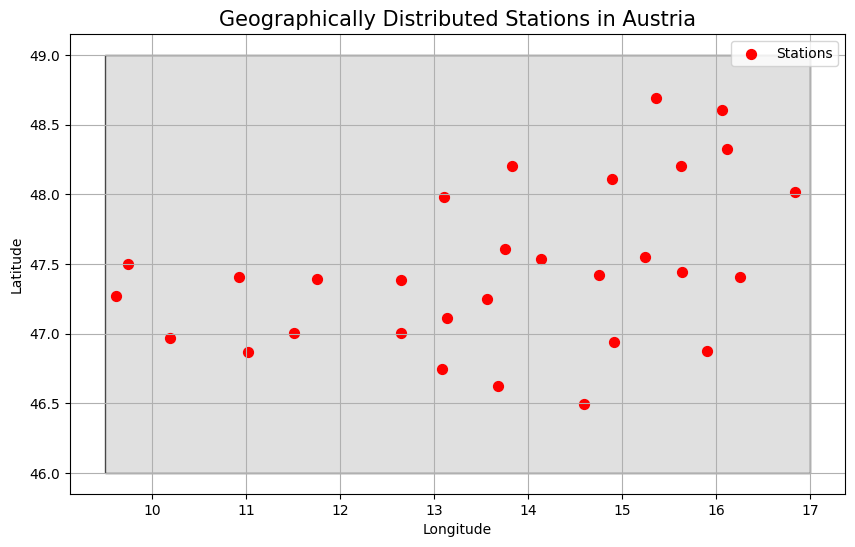

In [10]:
from shapely.geometry import Polygon
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Create Austria's boundary (approximation)
austria = gpd.GeoDataFrame({
    'country': ['Austria'],
    'geometry': [Polygon([(9.5, 46.0), (17.0, 46.0), (17.0, 49.0), (9.5, 49.0), (9.5, 46.0)])]
}, crs="EPSG:4326")

# Load the selected stations
selected_stations = pd.read_csv("distributed_stations.csv")
stations_gdf = gpd.GeoDataFrame(
    selected_stations,
    geometry=gpd.points_from_xy(selected_stations['lon'], selected_stations['lat']),
    crs="EPSG:4326"
)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
austria.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.7)
stations_gdf.plot(ax=ax, color="red", markersize=50, label="Stations")

# Add labels and legend
plt.title("Geographically Distributed Stations in Austria", fontsize=15)
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


In [11]:
import folium

# Load the selected stations from the CSV
selected_stations = pd.read_csv("distributed_stations.csv")

# Create a map centered on Austria
austria_map = folium.Map(location=[47.5, 14.5], zoom_start=7)  # Adjust center and zoom as needed

# Add station markers to the map
for _, row in selected_stations.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],  # Latitude and longitude of the station
        popup=f"Station: {row['name']}<br>Lat: {row['lat']}<br>Lon: {row['lon']}",  # Popup with station info
        icon=folium.Icon(color="red", icon="info-sign"),
    ).add_to(austria_map)

# Save the map to an HTML file and display it
austria_map.save("austrian_stations_map.html")
austria_map

### Parameters data

In [12]:
parameters_url = "https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-1d/metadata/parameters"

response = requests.get(parameters_url)

In [13]:
import io
parameters_data = pd.read_csv(io.StringIO(response.text))

# Extract the first column (assuming it's the parameter names)
parameter_names = parameters_data.iloc[:, 0]  # First column
parameter_names_list = parameter_names.tolist()
print(parameter_names_list)

['bewd_i', 'bewd_i_flag', 'bewd_ii', 'bewd_ii_flag', 'bewd_iii', 'bewd_iii_flag', 'bewm_i', 'bewm_i_flag', 'bewm_ii', 'bewm_ii_flag', 'bewm_iii', 'bewm_iii_flag', 'bewm_mittel', 'bewm_mittel_flag', 'bft6', 'bft6_flag', 'bft8', 'bft8_flag', 'cglo_j', 'cglo_j_flag', 'dampf_i', 'dampf_i_flag', 'dampf_ii', 'dampf_ii_flag', 'dampf_iii', 'dampf_iii_flag', 'dampf_mittel', 'dampf_mittel_flag', 'dd32_i', 'dd32_i_flag', 'dd32_ii', 'dd32_ii_flag', 'dd32_iii', 'dd32_iii_flag', 'erdb_i', 'erdb_i_flag', 'erdb_ii', 'erdb_ii_flag', 'erdb_iii', 'erdb_iii_flag', 'ffx', 'ffx_flag', 'gew', 'gew_flag', 'glatt', 'glatt_flag', 'nebel', 'nebel_flag', 'p_i', 'p_i_flag', 'p_ii', 'p_ii_flag', 'p_iii', 'p_iii_flag', 'p_mittel', 'p_mittel_flag', 'raureif', 'raureif_flag', 'reif', 'reif_flag', 'rfb_i', 'rfb_i_flag', 'rfb_ii', 'rfb_ii_flag', 'rfb_iii', 'rfb_iii_flag', 'rfb_mittel', 'rfb_mittel_flag', 'rf_i', 'rf_i_flag', 'rf_ii', 'rf_ii_flag', 'rf_iii', 'rf_iii_flag', 'rf_mittel', 'rf_mittel_flag', 'rr', 'rra_manu',

In [14]:
# prompt: save parameter_names_list to a file

with open('parameter_names.txt', 'w') as f:
    for item in parameter_names_list:
        f.write("%s\n" % item)

In [15]:
parameters_data.head()

,Parameterkürzel,Kurzbeschreibung,Beschreibung,Einheit
0,bewd_i,Bewölkungsdichte zum Beobachtungstermin I,Bewölkungsdichte zum Beobachtungstermin I (06 ...,code
1,bewd_i_flag,Qualitätsflag für Bewölkungsdichte zum Beobach...,Qualitätsflag für Bewölkungsdichte zum Beobach...,code
2,bewd_ii,Bewölkungsdichte zum Beobachtungstermin II,Bewölkungsdichte zum Beobachtungstermin II (13...,code
3,bewd_ii_flag,Qualitätsflag für Bewölkungsdichte zum Beobach...,Qualitätsflag für Bewölkungsdichte zum Beobach...,code
4,bewd_iii,Bewölkungsdichte zum Beobachtungstermin III,Bewölkungsdichte zum Beobachtungstermin III (1...,code


## Main dataset

First I will be working with the January 2016 dataset to fine-tune the pipeline. This will help me identify and resolve potential issues before scaling to a multi-year dataset.

In [16]:
selected_stations = selected_stations["id"].tolist()

api_url = "https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-1d"

# Define the query parameters
query_params = {
    "parameters": parameter_names_list,  # Parameter
    "start": "2016-01-01T00:00",  # Start date
    "end": "2016-01-31T23:59",  # End date
    "station_ids": selected_stations,  # Station IDs, comma-separated
    "output_format": "csv",  # Output format
}

# Make the GET request
response = requests.get(api_url, params=query_params)

# Check if the request was successful
if response.status_code == 200:
    # Save the response content to a CSV file
    with open("station_data_jan_2016.csv", "wb") as file:
        file.write(response.content)
    print("Data retrieved and saved as 'station_data_jan_2016.csv'")
else:
    # Print error details if the request fails
    print(f"Failed to retrieve data. Status code: {response.status_code}")
    print(response.json())

Data retrieved and saved as 'station_data_jan_2016.csv'


### Filter the days to fit ECMWF

In [17]:
file_path = "station_data_jan_2016.csv"
data = pd.read_csv(file_path)

print(data.head())
print(data.shape)

                     time  station  bewd_i  bewd_i_flag  bewd_ii  \
0  2016-01-01T00:00+00:00        8    2.00           20     1.00   
1  2016-01-01T00:00+00:00       66    2.00           20      NaN   
2  2016-01-01T00:00+00:00       68    2.00           20     2.00   
3  2016-01-01T00:00+00:00       93    2.00           20     2.00   
4  2016-01-01T00:00+00:00       27     NaN           20      NaN   

   bewd_ii_flag  bewd_iii  bewd_iii_flag  bewm_i  bewm_i_flag  ...  \
0            20      2.00             20   10.00           20  ...   
1            20       NaN             20    9.00           20  ...   
2            20       NaN             20   10.00           20  ...   
3            20      2.00             20   10.00           20  ...   
4            20       NaN             20     NaN           20  ...   

   vvbft_i_flag  vvbft_ii  vvbft_ii_flag  vvbft_iii  vvbft_iii_flag  \
0            20      1.00             20       0.00              20   
1            20      1.00   

In [18]:
data.head()

,time,station,bewd_i,bewd_i_flag,bewd_ii,bewd_ii_flag,bewd_iii,bewd_iii_flag,bewm_i,bewm_i_flag,...,vvbft_i_flag,vvbft_ii,vvbft_ii_flag,vvbft_iii,vvbft_iii_flag,vv_mittel,vv_mittel_flag,zeitx,zeitx_flag,substation
0,2016-01-01T00:00+00:00,8,2.00,20,1.00,20,2.00,20,10.00,20,...,20,1.00,20,0.00,20,0.20,20,1502.00,20,19204
1,2016-01-01T00:00+00:00,66,2.00,20,NaN,20,NaN,20,9.00,20,...,20,1.00,20,1.00,20,1.00,20,1611.00,20,17301
2,2016-01-01T00:00+00:00,68,2.00,20,2.00,20,NaN,20,10.00,20,...,20,2.00,20,1.00,20,2.60,20,706.00,20,15610
3,2016-01-01T00:00+00:00,93,2.00,20,2.00,20,2.00,20,10.00,20,...,20,3.00,20,2.00,20,2.60,20,1417.00,20,5609
4,2016-01-01T00:00+00:00,27,NaN,20,NaN,20,NaN,20,NaN,20,...,20,2.00,20,1.00,20,1.50,20,1049.00,20,4802


In [776]:
# Convert the date column to datetime format
data = data.rename(columns={'time': 'date'})
data['date'] = pd.to_datetime(data['date'])

# Extract date components
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

# Filter rows where the day of the week is Monday (0) or Thursday (3)
data = data[data['date'].dt.dayofweek.isin([0, 3])]
print(data.shape)

print(data.head())

(240, 136)
                        date  station  bewd_i  bewd_i_flag  bewd_ii  \
90 2016-01-04 00:00:00+00:00        8     2.0           20      2.0   
91 2016-01-04 00:00:00+00:00       66     1.0           20      1.0   
92 2016-01-04 00:00:00+00:00       68     2.0           20      2.0   
93 2016-01-04 00:00:00+00:00       93     2.0           20      2.0   
94 2016-01-04 00:00:00+00:00       27     NaN           20      NaN   

    bewd_ii_flag  bewd_iii  bewd_iii_flag  bewm_i  bewm_i_flag  ...  \
90            20       2.0             20    10.0           20  ...   
91            20       2.0             20     9.0           20  ...   
92            20       1.0             20    10.0           20  ...   
93            20       2.0             20    10.0           20  ...   
94            20       NaN             20     NaN           20  ...   

    vvbft_iii  vvbft_iii_flag  vv_mittel  vv_mittel_flag   zeitx  zeitx_flag  \
90        1.0              20        1.5              2

In [777]:
# # Encode month as cyclical feature
# data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
# data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# # Encode day of the week as cyclical feature
# data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
# data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

In [778]:
data = data.rename(columns={'station': 'id'})


merged_data = pd.merge(data, distributed_stations[["id", "lat", "lon", "name"]], on="id", how="left")
print(merged_data)

                         date  id  bewd_i  bewd_i_flag  bewd_ii  bewd_ii_flag  \
0   2016-01-04 00:00:00+00:00   8     2.0           20      2.0            20   
1   2016-01-04 00:00:00+00:00  66     1.0           20      1.0            20   
2   2016-01-04 00:00:00+00:00  68     2.0           20      2.0            20   
3   2016-01-04 00:00:00+00:00  93     2.0           20      2.0            20   
4   2016-01-04 00:00:00+00:00  27     NaN           20      NaN            20   
..                        ...  ..     ...          ...      ...           ...   
235 2016-01-28 00:00:00+00:00  37     1.0           20      1.0            20   
236 2016-01-28 00:00:00+00:00  20     NaN           20      NaN            20   
237 2016-01-28 00:00:00+00:00  71     1.0           20      0.0            20   
238 2016-01-28 00:00:00+00:00  43     NaN           20      NaN            20   
239 2016-01-28 00:00:00+00:00  15     NaN           20      NaN            20   

     bewd_iii  bewd_iii_fla

## Flag columns

When we look at the data, we can notice a lot of flag columns. Let's inpect them:

In [779]:
quality_flag_columns = [col for col in merged_data.columns if 'flag' in col]
for column in quality_flag_columns:
    unique_values = merged_data[column].unique()
    print(f"Unique values for column '{column}': {unique_values}")

Unique values for column 'bewd_i_flag': [20]
Unique values for column 'bewd_ii_flag': [20]
Unique values for column 'bewd_iii_flag': [20]
Unique values for column 'bewm_i_flag': [20]
Unique values for column 'bewm_ii_flag': [20]
Unique values for column 'bewm_iii_flag': [20]
Unique values for column 'bewm_mittel_flag': [20]
Unique values for column 'bft6_flag': [nan]
Unique values for column 'bft8_flag': [nan]
Unique values for column 'cglo_j_flag': [20]
Unique values for column 'dampf_i_flag': [20]
Unique values for column 'dampf_ii_flag': [20]
Unique values for column 'dampf_iii_flag': [20]
Unique values for column 'dampf_mittel_flag': [20]
Unique values for column 'dd32_i_flag': [20]
Unique values for column 'dd32_ii_flag': [20]
Unique values for column 'dd32_iii_flag': [20]
Unique values for column 'erdb_i_flag': [20]
Unique values for column 'erdb_ii_flag': [20]
Unique values for column 'erdb_iii_flag': [20]
Unique values for column 'ffx_flag': [20]
Unique values for column 'gew_f

In the parameters metadata flag columns are described as quality flags for the corresponding numerical column and they contain the code.

By printing unique values for all these columns, we can notice that we have :
1. Uniform Values ([20]):

Most flags have the value 20 across all rows. These columns are not providing any variability or useful information.
Examples: bewd_i_flag, bewd_ii_flag, bewm_i_flag, etc.

2. Columns with NaN Values:

Some flags are entirely NaN, which means they also contain no usable information.
Examples: bft6_flag, bft8_flag, gew_flag, etc.

Hence, we will simply drop all the flag columns.


In [780]:
data_cleaned = merged_data.drop(columns=quality_flag_columns)
print(f"Remaining columns: {data_cleaned.columns}")
print("New dataset size:", data_cleaned.shape)

Remaining columns: Index(['date', 'id', 'bewd_i', 'bewd_ii', 'bewd_iii', 'bewm_i', 'bewm_ii',
       'bewm_iii', 'bewm_mittel', 'bft6', 'bft8', 'cglo_j', 'dampf_i',
       'dampf_ii', 'dampf_iii', 'dampf_mittel', 'dd32_i', 'dd32_ii',
       'dd32_iii', 'erdb_i', 'erdb_ii', 'erdb_iii', 'ffx', 'gew', 'glatt',
       'nebel', 'p_i', 'p_ii', 'p_iii', 'p_mittel', 'raureif', 'reif', 'rfb_i',
       'rfb_ii', 'rfb_iii', 'rfb_mittel', 'rf_i', 'rf_ii', 'rf_iii',
       'rf_mittel', 'rr', 'rra_manu', 'rra_manu_i', 'rra_manu_iii', 'rr_i',
       'rr_iii', 'sh', 'sha_manu', 'sh_manu', 'shneu_manu', 'sicht_i',
       'sicht_ii', 'sicht_iii', 'so_h', 'tau', 'tl_i', 'tl_ii', 'tl_iii',
       'tlmax', 'tlmin', 'tl_mittel', 'tsmin', 'vvbft_i', 'vvbft_ii',
       'vvbft_iii', 'vv_mittel', 'zeitx', 'substation', 'year', 'month', 'day',
       'lat', 'lon', 'name'],
      dtype='object')
New dataset size: (240, 74)


## Visualizing target features

Target features are tlmax (Lufttemperatur 2m Maximalwert), tlmin (Lufttemperatur 2m Minimalwert) and tl_mittel (Lufttemperatur 2m Mittelwert). Let's plot them for all stations:

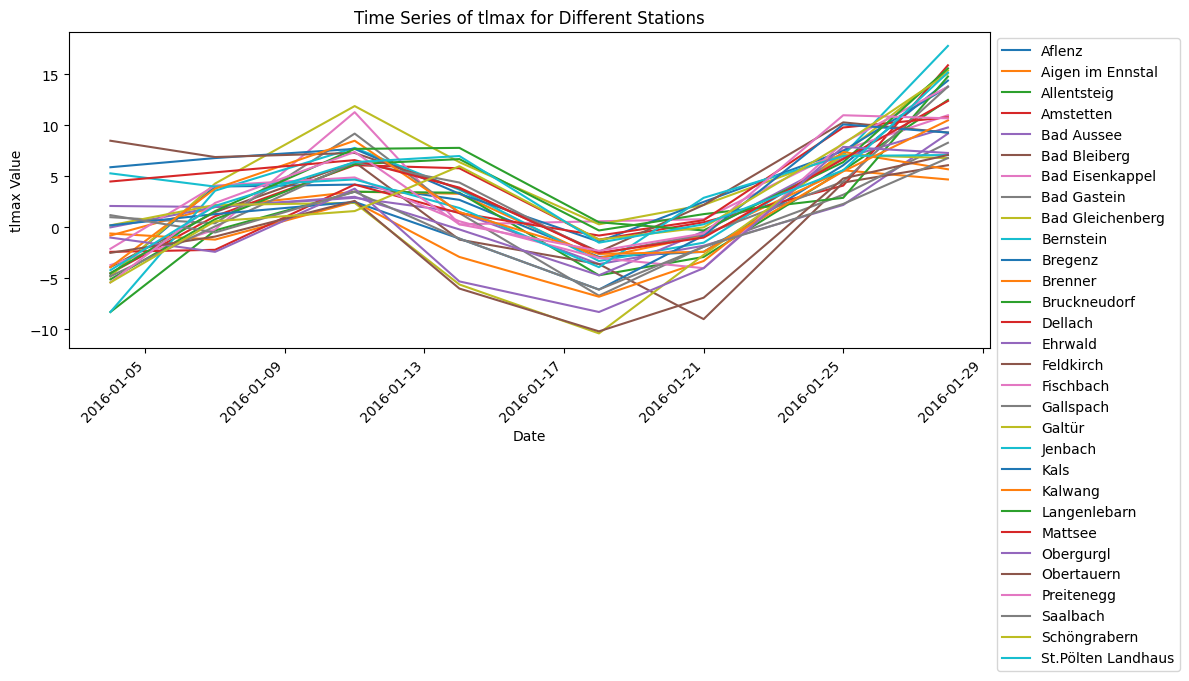

In [781]:
import matplotlib.dates as mdates

# Group data by station and plot
fig, ax = plt.subplots(figsize=(12, 6))
for station, station_group in data_cleaned.groupby("name"):
    station_group.plot(x="date", y="tlmax", ax=ax, label=station)

# Rotate x-axis labels and format dates
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees

ax.set_xlabel("Date")
ax.set_ylabel("tlmax Value")
ax.set_title("Time Series of tlmax for Different Stations")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Adjust legend location as needed
plt.tight_layout()
plt.show()

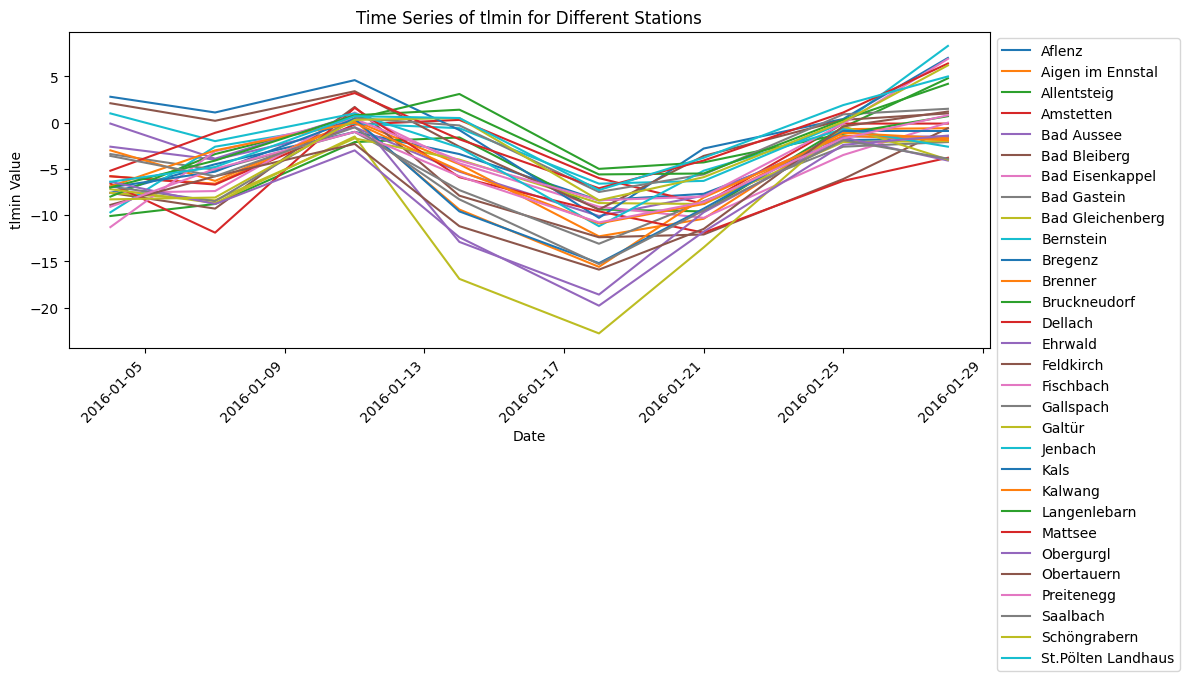

In [782]:
# Group data by station and plot
fig, ax = plt.subplots(figsize=(12, 6))
for station, station_group in data_cleaned.groupby("name"):
    station_group.plot(x="date", y="tlmin", ax=ax, label=station)

# Rotate x-axis labels and format dates
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees

ax.set_xlabel("Date")
ax.set_ylabel("tlmin Value")
ax.set_title("Time Series of tlmin for Different Stations")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Adjust legend location as needed
plt.tight_layout()
plt.show()

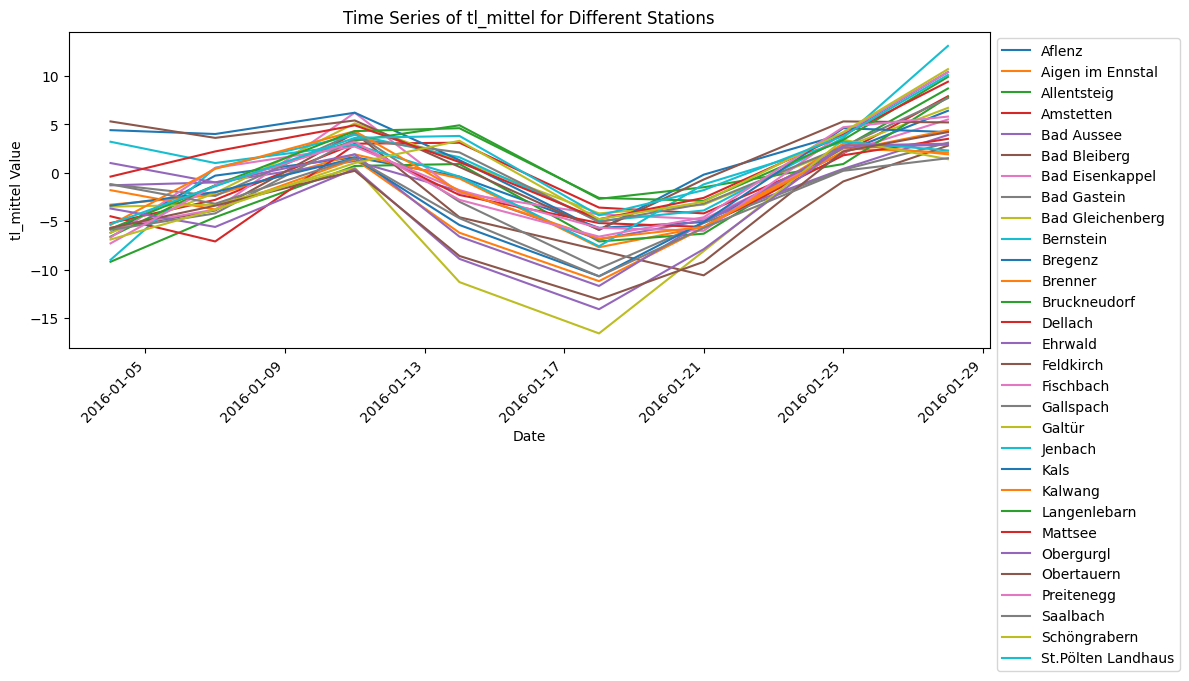

In [783]:
# Group data by station and plot
fig, ax = plt.subplots(figsize=(12, 6))
for station, station_group in data_cleaned.groupby("name"):
    station_group.plot(x="date", y="tl_mittel", ax=ax, label=station)

# Rotate x-axis labels and format dates
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees

ax.set_xlabel("Date")
ax.set_ylabel("tl_mittel Value")
ax.set_title("Time Series of tl_mittel for Different Stations")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Adjust legend location as needed
plt.tight_layout()
plt.show()

## Missing values

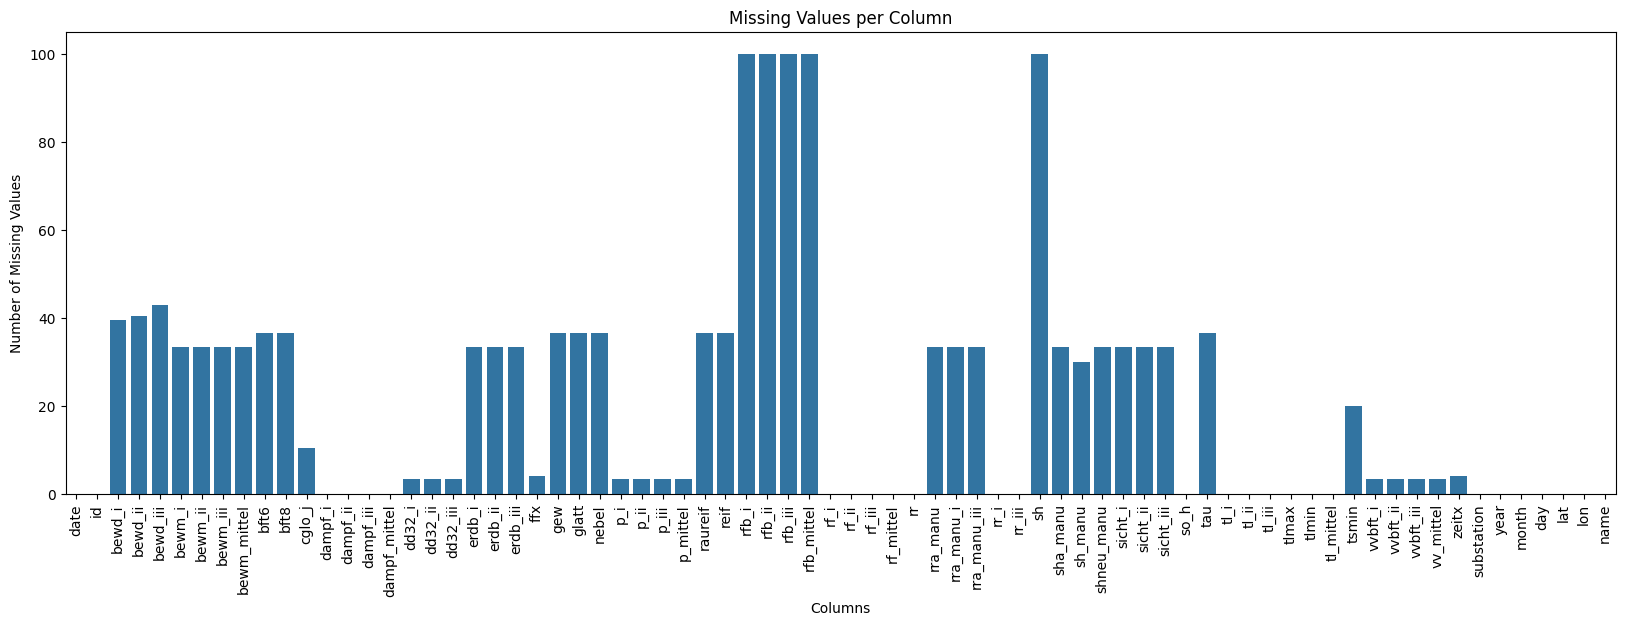

In [784]:
# Check missing values
missing_values = data_cleaned.isnull().sum()
missing_values_per = missing_values / len(data_cleaned) * 100

# Create a bar plot for missing values
plt.figure(figsize=(20, 6))
sns.barplot(x=missing_values.index, y=missing_values_per.values)
plt.xticks(rotation=90)
plt.title("Missing Values per Column")
plt.ylabel("Number of Missing Values")
plt.xlabel("Columns")
plt.show()

Columns with missing values differ in the proportion of missing values. We will divide them into 3 categories:

* Columns with 100% missing values - we will simply remove them, because they do not carry any information
* Columns with > 5 missing values - we will have to investigate them
* Columns with < 5 and > 0 missing values - we will imput missing values


### High missing values

In [785]:
# Identify columns with 100% missing values
columns_to_drop = missing_values_per[missing_values_per > 99].index
print("Dropped the columns: ", columns_to_drop.values)
missing_values_per = missing_values_per[missing_values_per <= 99]

# Drop the identified columns from the DataFrame
data_cleaned = data_cleaned.drop(columns=columns_to_drop)

# Now filtered_data contains the DataFrame with the columns dropped.
print("Dataset size after removing columns with 100% missing values:", data_cleaned.shape)

Dropped the columns:  ['rfb_i' 'rfb_ii' 'rfb_iii' 'rfb_mittel' 'sh']
Dataset size after removing columns with 100% missing values: (240, 69)


### Moderate missing values

In [786]:
columns_with_moderate_missing = missing_values_per[missing_values_per > 5]
columns_with_moderate_missing

,0
bewd_i,39.583333
bewd_ii,40.416667
bewd_iii,42.916667
bewm_i,33.333333
bewm_ii,33.333333
bewm_iii,33.333333
bewm_mittel,33.333333
bft6,36.666667
bft8,36.666667
cglo_j,10.416667


In [787]:
# Step 1: Filter `parameter_data` to include only parameters with missing values
# Extract the parameter names from `columns_with_moderate_missing`
columns_with_moderate_missing_names = columns_with_moderate_missing.index

# Filter `parameter_data` based on these parameter names
parameters_with_moderate_missing = parameters_data[parameters_data['Parameterkürzel'].isin(columns_with_moderate_missing_names)]

# Step 2: Merge the missing percentages with the explanations
# Create a DataFrame for the missing percentages
missing_df = columns_with_moderate_missing.reset_index()
missing_df.columns = ['Parameterkürzel', 'Missing Percentage']

# Merge the two DataFrames on the `Parameterkürzel` column
merged_data = pd.merge(missing_df, parameters_with_moderate_missing, on='Parameterkürzel', how='inner')

# Step 3: Print the result
print("Parameters with Missing Values > 20%:")
print(merged_data[['Parameterkürzel','Beschreibung', 'Missing Percentage']])


Parameters with Missing Values > 20%:
   Parameterkürzel                                       Beschreibung  \
0           bewd_i  Bewölkungsdichte zum Beobachtungstermin I (06 ...   
1          bewd_ii  Bewölkungsdichte zum Beobachtungstermin II (13...   
2         bewd_iii  Bewölkungsdichte zum Beobachtungstermin III (1...   
3           bewm_i  Bewölkungsmenge zum Beobachtungstermin I (06 U...   
4          bewm_ii  Bewölkungsmenge zum Beobachtungstermin II (13 ...   
5         bewm_iii  Bewölkungsmenge zum Beobachtungstermin III (18...   
6      bewm_mittel  Bewölkungsmenge, Tagesmittelwert berechnet aus...   
7             bft6  Windstärke >= 6 Beaufort oder >= 60 km/h - Cod...   
8             bft8  Windstärke >= 8 Beaufort oder >= 80 km/h - Cod...   
9           cglo_j  Globalstrahlung, kalibrierte 24-Stundensumme a...   
10          erdb_i  Erdbodenzustand zum Beobachtungstermin I (06 U...   
11         erdb_ii  Erdbodenzustand zum Beobachtungstermin II (13 ...   
12        erd

These parameters have 30%–42% missing values, which is significant. Everything connected to cloud cover is 30-40% missing. Storm, ground conditions, rare weather events and snow related parameters are also missing. We will now check, how the missing values are distributed for different stations.

<ipython-input-788-1012328fa7b2>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_station = relevant_parameters.groupby(stations_column).apply(lambda x: x.isnull().mean() * 100)


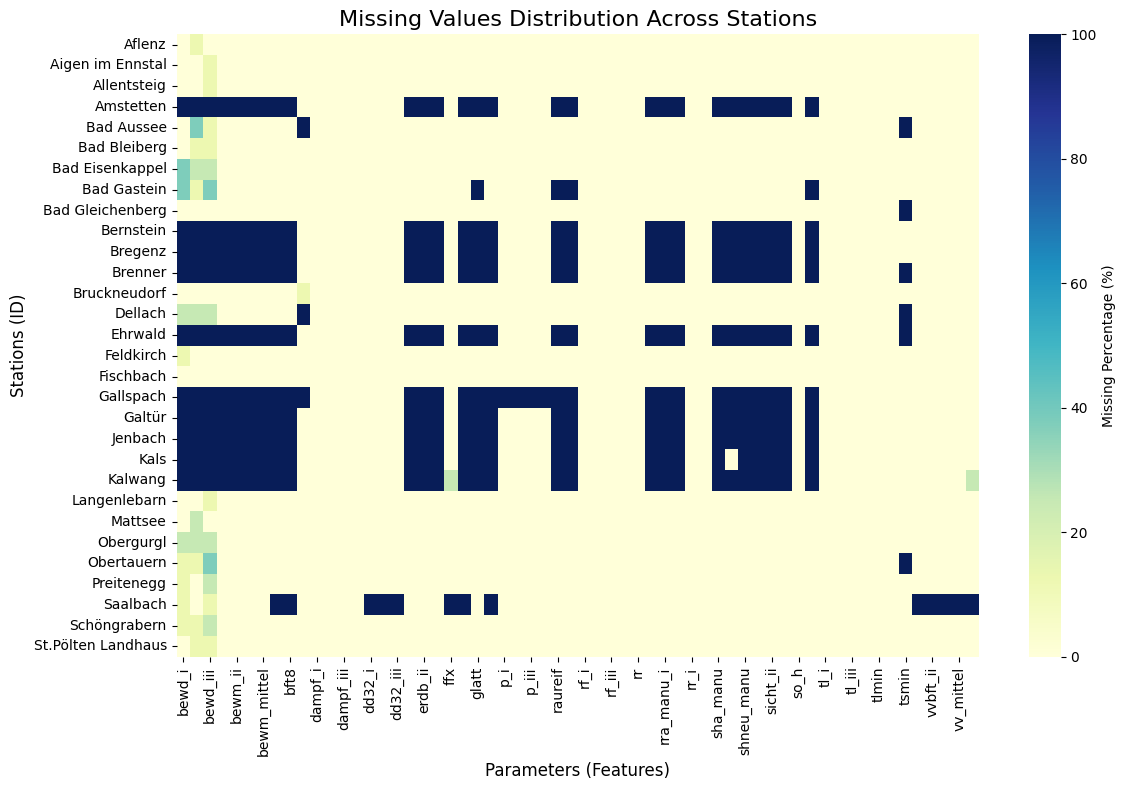

In [788]:
# Step 1: Filter the dataset to include only relevant parameters and station
# (Assume 'id' is the station column in data_cleaned)
stations_column = 'name'
relevant_parameters = data_cleaned.drop(columns=['date', 'year', 'month', 'day', 'lat', 'lon', 'id', 'substation'])  # Adjust as needed

# Step 2: Calculate the percentage of missing values for each station
missing_by_station = relevant_parameters.groupby(stations_column).apply(lambda x: x.isnull().mean() * 100)

parameter_names = missing_by_station.columns
filtered_missing_by_station = missing_by_station[parameter_names].drop(['name'], axis=1)

# Step 4: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    filtered_missing_by_station,
    cmap="YlGnBu",
    annot=False,
    cbar_kws={'label': 'Missing Percentage (%)'}
)

plt.title("Missing Values Distribution Across Stations", fontsize=16)
plt.xlabel("Parameters (Features)", fontsize=12)
plt.ylabel("Stations (ID)", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Let's check the missing percentage for each station:

In [789]:
# Step 1: Group by station name and calculate the missing percentage
missing_by_name = data_cleaned.groupby('name').apply(lambda x: x.isnull().mean() * 100)

# Step 2: Sort the results by the overall missing percentage for better understanding
missing_by_name['Overall Missing Percentage'] = missing_by_name.mean(axis=1)
missing_by_name_sorted = missing_by_name.sort_values('Overall Missing Percentage', ascending=False)

# Step 3: Display the result
print(missing_by_name_sorted['Overall Missing Percentage'])

name
Gallspach             46.376812
Brenner               40.579710
Ehrwald               40.579710
Kalwang               39.855072
Amstetten             39.130435
Galtür                39.130435
Bernstein             39.130435
Bregenz               39.130435
Jenbach               39.130435
Kals                  37.681159
Saalbach              19.202899
Bad Gastein            7.065217
Dellach                3.985507
Bad Aussee             3.623188
Obertauern             2.355072
Bad Gleichenberg       1.449275
Bad Eisenkappel        1.268116
Obergurgl              1.086957
Schöngrabern           0.724638
Preitenegg             0.543478
Mattsee                0.362319
Bad Bleiberg           0.362319
St.Pölten Landhaus     0.362319
Aflenz                 0.181159
Langenlebarn           0.181159
Aigen im Ennstal       0.181159
Bruckneudorf           0.181159
Allentsteig            0.181159
Feldkirch              0.181159
Fischbach              0.000000
Name: Overall Missing Percentage, d

<ipython-input-789-d576e6de7a1a>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_name = data_cleaned.groupby('name').apply(lambda x: x.isnull().mean() * 100)


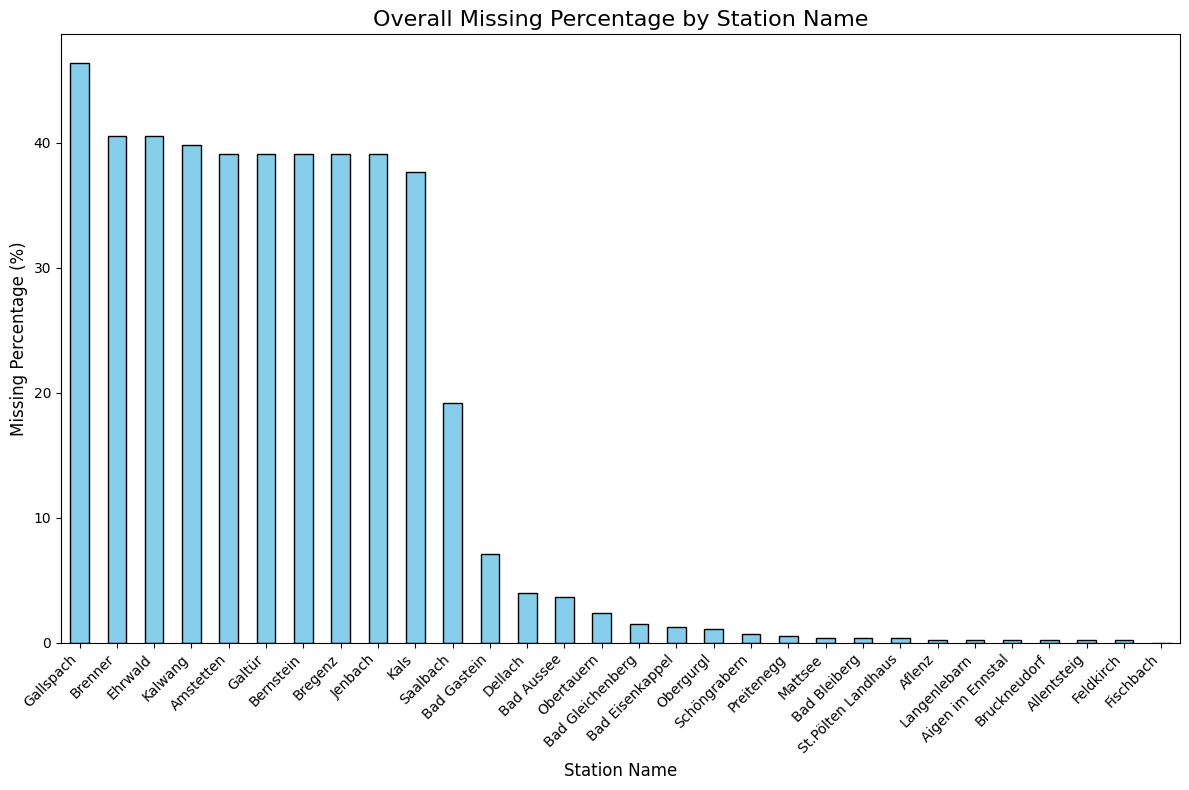

In [790]:
# Step 1: Extract overall missing percentage
station_missing_summary = missing_by_name_sorted['Overall Missing Percentage']

# Step 2: Plot a bar chart
plt.figure(figsize=(12, 8))
station_missing_summary.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Overall Missing Percentage by Station Name", fontsize=16)
plt.xlabel("Station Name", fontsize=12)
plt.ylabel("Missing Percentage (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

We can see that some parameters are not measured for specific stations, leading to missing values.

How to deal with them?

### Distribution of features

In [791]:
relevant_parameters.drop(["name"], axis=1)

,bewd_i,bewd_ii,bewd_iii,bewm_i,bewm_ii,bewm_iii,bewm_mittel,bft6,bft8,cglo_j,...,tl_iii,tlmax,tlmin,tl_mittel,tsmin,vvbft_i,vvbft_ii,vvbft_iii,vv_mittel,zeitx
0,2.0,2.0,2.0,10.0,10.0,10.0,100.0,0.0,0.0,136.0,...,-7.5,-4.8,-7.6,-6.2,NaN,2.0,1.0,1.0,1.5,233.0
1,1.0,1.0,2.0,9.0,9.0,10.0,93.0,0.0,0.0,420.0,...,-4.4,-1.0,-6.4,-3.7,-7.3,0.0,1.0,0.0,0.2,1423.0
2,2.0,2.0,1.0,10.0,10.0,6.0,87.0,0.0,0.0,272.0,...,-4.0,-2.5,-8.9,-5.7,NaN,4.0,1.0,3.0,3.8,43.0
3,2.0,2.0,2.0,10.0,10.0,10.0,100.0,0.0,0.0,169.0,...,-6.4,-4.2,-6.4,-5.3,-6.0,2.0,2.0,1.0,2.1,211.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.2,-4.8,-6.9,-5.9,-7.2,2.0,2.0,1.0,2.1,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,1.0,1.0,2.0,10.0,9.0,10.0,97.0,0.0,0.0,459.0,...,6.8,15.1,6.2,10.7,4.1,2.0,5.0,2.0,4.5,1253.0
236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,767.0,...,2.8,9.8,-4.1,2.9,NaN,0.0,1.0,0.0,0.2,326.0
237,1.0,0.0,0.0,3.0,3.0,4.0,33.0,0.0,0.0,885.0,...,4.5,10.7,0.8,5.8,-2.9,1.0,2.0,2.0,2.1,2310.0
238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,618.0,...,2.8,9.3,-0.9,4.2,-2.9,0.0,0.0,1.0,0.2,1116.0


In [792]:
for column in relevant_parameters.drop(["name"], axis=1).columns:
    if relevant_parameters[column].dtype in ['int64', 'float64']:  # Check if the column is numeric
        unique_values = relevant_parameters[column].unique()
        print(f"Unique values for column '{column}' ('{parameters_data[parameters_data['Parameterkürzel']==column]['Kurzbeschreibung'].values[0]}'): {unique_values}")

Unique values for column 'bewd_i' ('Bewölkungsdichte zum Beobachtungstermin I'): [ 2.  1. nan  0.]
Unique values for column 'bewd_ii' ('Bewölkungsdichte zum Beobachtungstermin II'): [ 2.  1. nan  0.]
Unique values for column 'bewd_iii' ('Bewölkungsdichte zum Beobachtungstermin III'): [ 2.  1. nan  0.]
Unique values for column 'bewm_i' ('Bewölkungsmenge zum Beobachtungstermin I'): [10.  9. nan  7.  4.  1.  0.  8.  3.  5.  6.  2.]
Unique values for column 'bewm_ii' ('Bewölkungsmenge zum Beobachtungstermin II'): [10.  9. nan  7.  5.  8.  6.  3.  2.  4.  0.  1.]
Unique values for column 'bewm_iii' ('Bewölkungsmenge zum Beobachtungstermin III'): [10.  6. nan  0.  8.  9.  7.  3.  5.  4.  1.  2.]
Unique values for column 'bewm_mittel' ('Bewölkungsmenge Mittelwert'): [100.  93.  87.  nan  57.  83.  97.  60.  77.  73.  40.  70.  80.  43.
  47.  53.  67.  90.   7.  20.  63.  50.  37.  23.  33.  30.   0.  27.
  17.   3.  10.]
Unique values for column 'bft6' ('Sturm Indikator'): [ 0. nan  1.]
Uniq

## Indicator Features

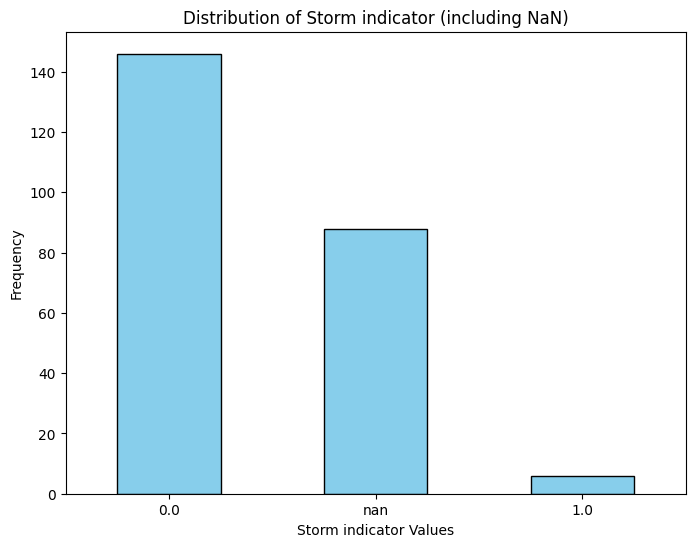

In [793]:
# Calculate value counts, including NaN
value_counts = data_cleaned['bft6'].value_counts(dropna=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Storm indicator (including NaN)')
plt.xlabel('Storm indicator Values')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

For column Storm Indicator we could treat missing values as 0, assuming that event didn't occur. But since the number of NaN is quite high, it was decided to imput values based on the data from the other close station.

In [794]:
# Fill NaN values in the 'bft6' column with 0
# data_cleaned['bft6'] = data_cleaned['bft6'].fillna(0)

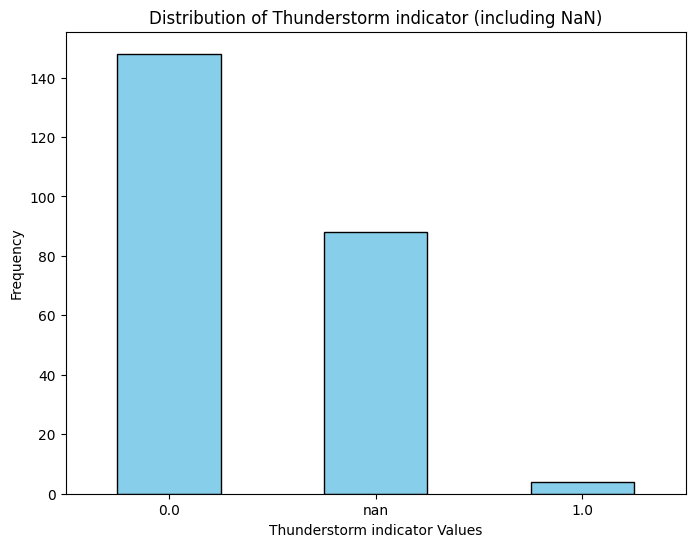

In [795]:
# Calculate value counts, including NaN
value_counts = data_cleaned['gew'].value_counts(dropna=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Thunderstorm indicator (including NaN)')
plt.xlabel('Thunderstorm indicator Values')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

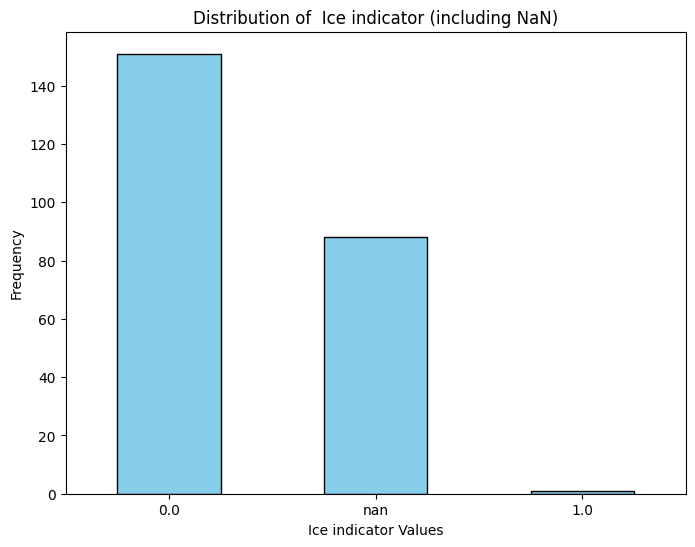

In [796]:
# Calculate value counts, including NaN
value_counts = data_cleaned['glatt'].value_counts(dropna=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of  Ice indicator (including NaN)')
plt.xlabel('Ice indicator Values')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

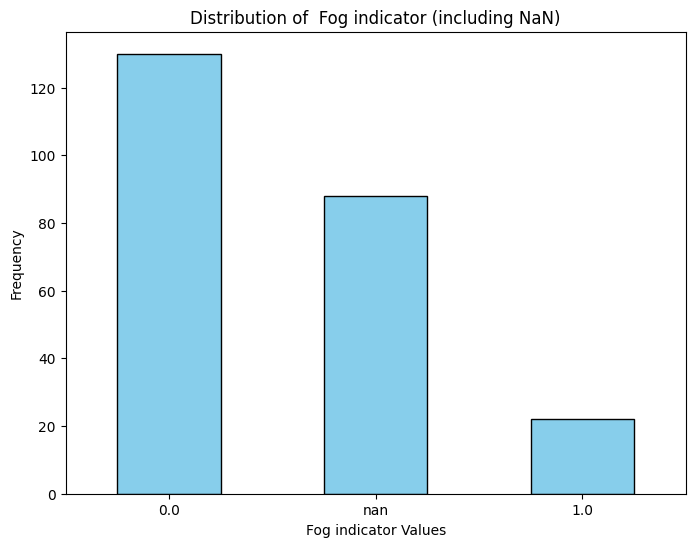

In [797]:
# Calculate value counts, including NaN
value_counts = data_cleaned['nebel'].value_counts(dropna=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of  Fog indicator (including NaN)')
plt.xlabel('Fog indicator Values')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

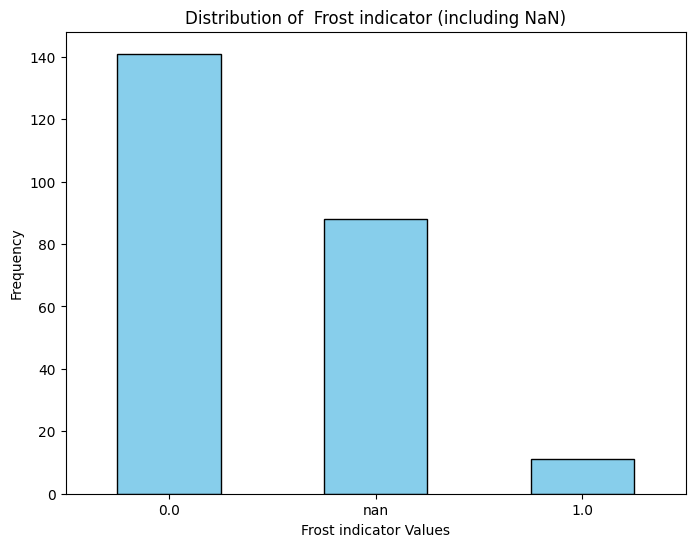

In [798]:
# Calculate value counts, including NaN
value_counts = data_cleaned['raureif'].value_counts(dropna=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of  Frost indicator (including NaN)')
plt.xlabel('Frost indicator Values')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

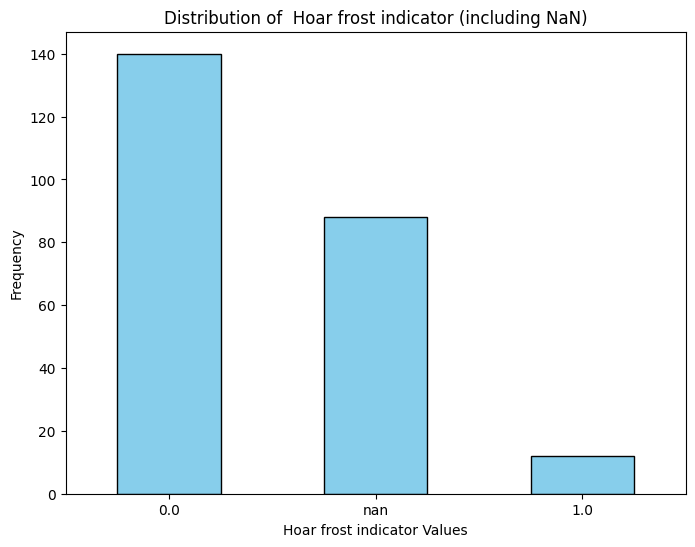

In [799]:
# Calculate value counts, including NaN
value_counts = data_cleaned['reif'].value_counts(dropna=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of  Hoar frost indicator (including NaN)')
plt.xlabel('Hoar frost indicator Values')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

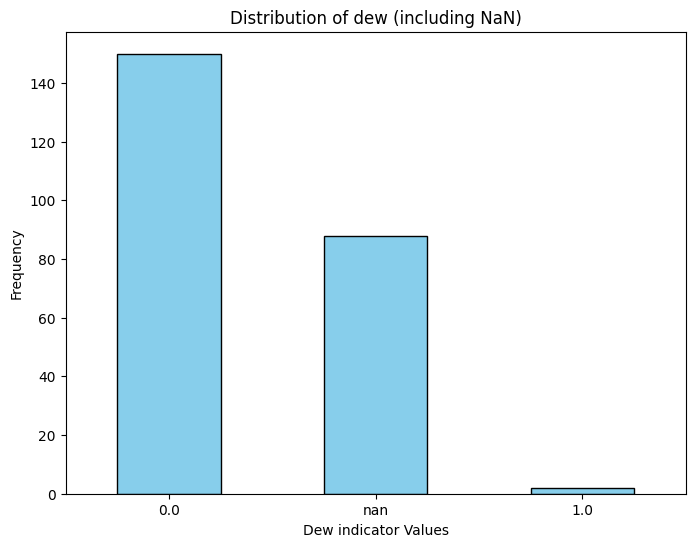

In [800]:
# Calculate value counts, including NaN
value_counts = data_cleaned['tau'].value_counts(dropna=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of dew (including NaN)')
plt.xlabel('Dew indicator Values')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

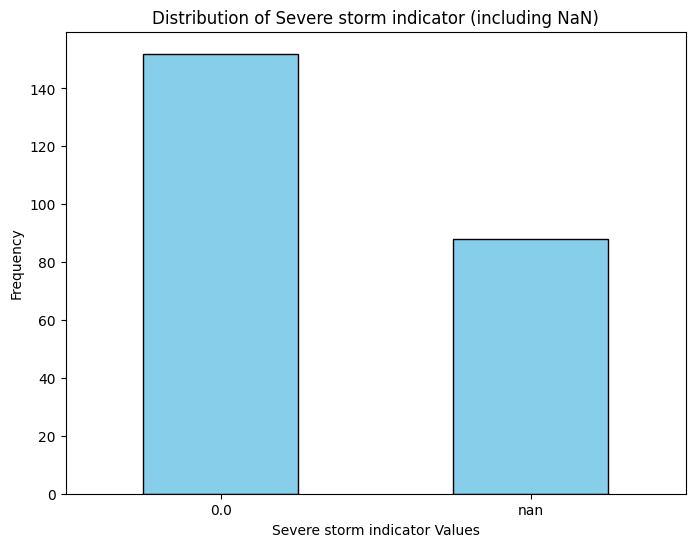

In [801]:
value_counts = data_cleaned['bft8'].value_counts(dropna=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Severe storm indicator (including NaN)')
plt.xlabel('Severe storm indicator Values')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

We see that the severe storm indicator has only one unique value of 0 (no severe storm) and missing values. So, we will remove this feature, since there is no variation in this feature.

In [802]:
data_cleaned = data_cleaned.drop(['bft8'], axis=1)

## Aggregated Features

In our dataset we have aggregated features, for example, bewm_mittel. It is calculated as (bewm_i + bewm_ii + bewm_iii)/3 * 10. Including both the individual features and the aggregation creates redundant information, which can inflate the importance of cloud cover in the model.


So, we need to choose if we will leave individual features or an aggregated feature in the dataset.

Our target features (tlmax, tlmin, tl_mittel) are strongly influenced by time-specific weather conditions:
* tlmax (maximum temperature) is directly affected by
conditions during the daytime.


* tlmin (minimum temperature) is influenced by overnight conditions.


Aggregating the features into bewm_mittel assumes that all three time periods contribute equally to the temperature patterns. However cloud cover at 06 UTC (morning) may have a different impact on temperature than at 18 UTC (evening).


Hence, we will be using individual features.

In [803]:
print(data_cleaned[['bewm_i', 'bewm_ii', 'bewm_iii', 'bewm_mittel']])

     bewm_i  bewm_ii  bewm_iii  bewm_mittel
0      10.0     10.0      10.0        100.0
1       9.0      9.0      10.0         93.0
2      10.0     10.0       6.0         87.0
3      10.0     10.0      10.0        100.0
4       NaN      NaN       NaN          NaN
..      ...      ...       ...          ...
235    10.0      9.0      10.0         97.0
236     NaN      NaN       NaN          NaN
237     3.0      3.0       4.0         33.0
238     NaN      NaN       NaN          NaN
239     NaN      NaN       NaN          NaN

[240 rows x 4 columns]


In [804]:
data_cleaned = data_cleaned.drop(['bewm_mittel'], axis=1)

We will apply the same logic for all aggregated features: dampf_mittel, p_mittel, rf_mittel, vv_mittel, rr, rra_manu.

In [805]:
data_cleaned = data_cleaned.drop(['dampf_mittel', 'p_mittel', 'rf_mittel', 'vv_mittel', 'rr', 'rra_manu'], axis=1)

## Nominal Features

<ipython-input-806-9b98688ede2a>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([rra_manu_mapping[int(float(label.get_text()))] for label in ax.get_xticklabels()])


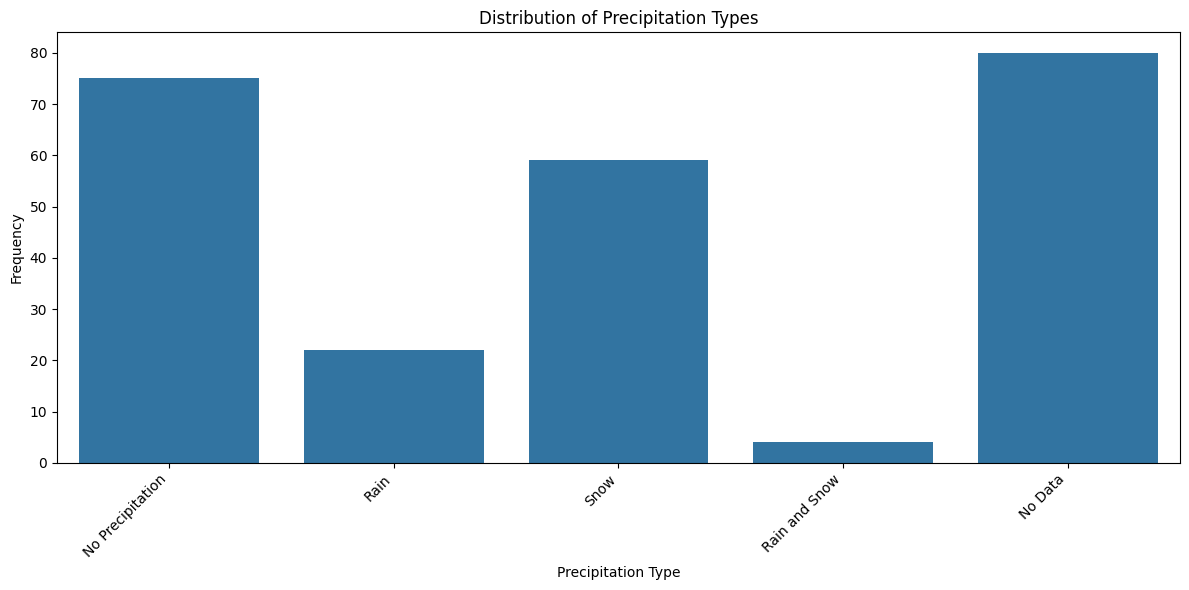

In [806]:
# Mapping for rra_manu codes to descriptions, including NaN
rra_manu_mapping = {
    0: 'No Precipitation',
    1: 'Rain',
    2: 'Snow',
    3: 'Graupel',
    4: 'Hail',
    5: 'Rain and Snow',
    6: 'Rain and Graupel',
    7: 'Rain and Hail',
    8: 'Snow and Graupel',
    9: 'Graupel and Hail',
    10: 'Rain, Snow, and Graupel',
    11: 'Rain, Graupel, and Hail',
    12: 'Snow and Hail',
    13: 'Rain, Snow, and Hail',
    14: 'Snow, Graupel, and Hail',
    15: 'Rain, Snow, Graupel, and Hail',
    99: 'No Data'
}

# Replace NaN values in 'rra_manu_i' with a string '99' temporarily for plotting
data_cleaned['rra_manu_i_plot'] = data_cleaned['rra_manu_i'].fillna(99)

# Plotting the distribution of precipitation types
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='rra_manu_i_plot', data=data_cleaned)
ax.set_xticklabels([rra_manu_mapping[int(float(label.get_text()))] for label in ax.get_xticklabels()])
plt.xlabel("Precipitation Type")
plt.ylabel("Frequency")
plt.title("Distribution of Precipitation Types")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Remove the temporary column after plotting
data_cleaned.drop(columns=['rra_manu_i_plot'], inplace=True)


This feature is a bit complicated and we will simplify it by just extracting rain information to a new column.

In [807]:
# Define the set of values indicating rain in the 'rra_manu_i' column
rain_values = [1, 5, 6, 7, 10, 11, 13, 15]

# Create the 'regen_i' column based on the condition
data_cleaned['regen_i'] = data_cleaned['rra_manu_i'].apply(lambda x: 1 if x in rain_values else 0)
data_cleaned['regen_ii'] = data_cleaned['rra_manu_iii'].apply(lambda x: 1 if x in rain_values else 0)
data_cleaned = data_cleaned.drop(['rra_manu_i', 'rra_manu_iii'], axis=1)

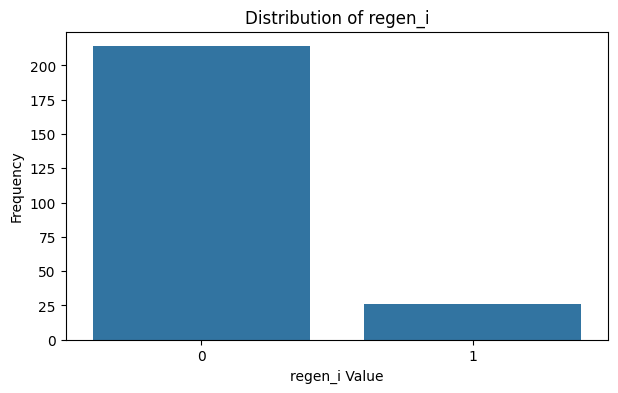

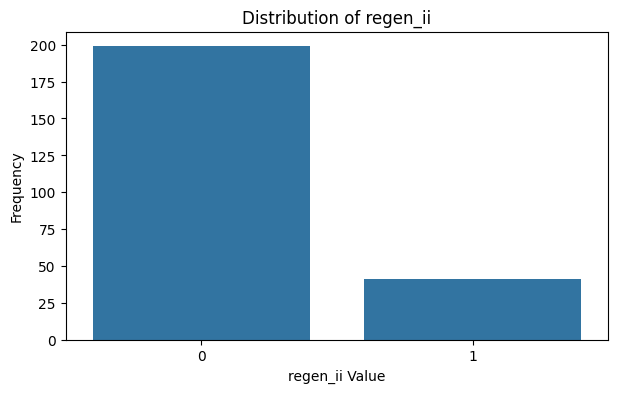

In [808]:
plt.figure(figsize=(7, 4))
sns.countplot(x='regen_i', data=data_cleaned)
plt.title('Distribution of regen_i')
plt.xlabel('regen_i Value')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(7, 4))
sns.countplot(x='regen_ii', data=data_cleaned)
plt.title('Distribution of regen_ii')
plt.xlabel('regen_ii Value')
plt.ylabel('Frequency')
plt.show()

<ipython-input-809-e8ba9ba41ffc>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([soil_condition_mapping[int(float(label.get_text()))] for label in ax.get_xticklabels()])


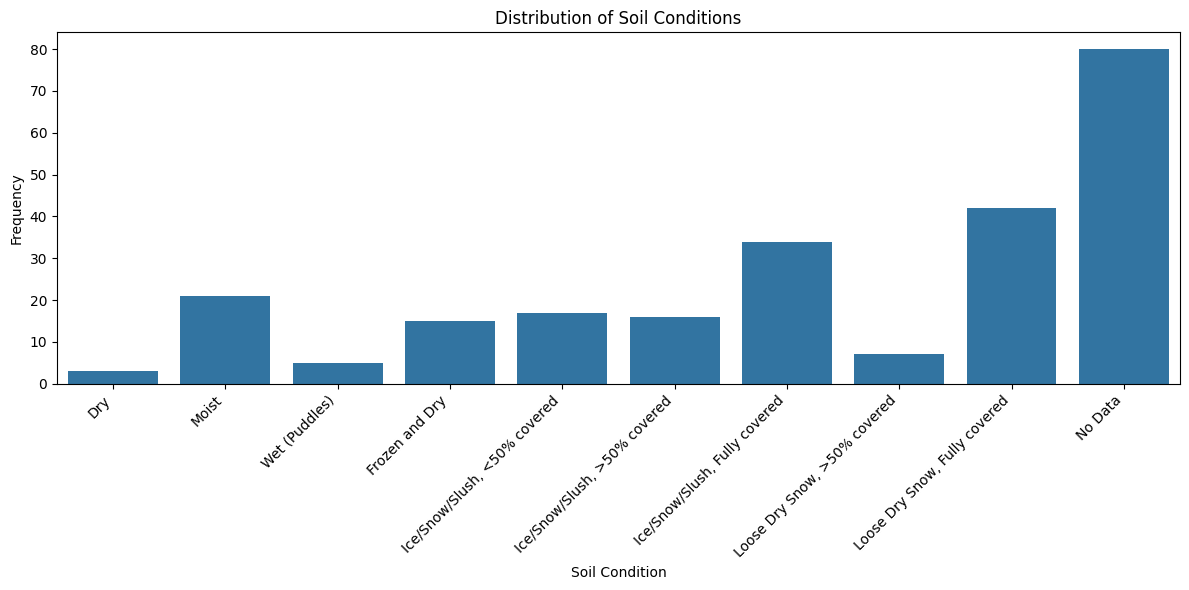

In [809]:
# Mapping for soil condition codes to descriptions
soil_condition_mapping = {
    0: 'Dry',
    1: 'Moist',
    2: 'Wet (Puddles)',
    3: 'Frozen and Dry',
    4: 'Ice/Snow/Slush',
    5: 'Ice/Snow/Slush, <50% covered',
    6: 'Ice/Snow/Slush, >50% covered',
    7: 'Ice/Snow/Slush, Fully covered',
    8: 'Loose Dry Snow, >50% covered',
    9: 'Loose Dry Snow, Fully covered',
    99: 'No Data'
}

# Replace NaN values in 'erdb_i' with a string 'NaN' temporarily for plotting
data_cleaned['erdb_i_plot'] = data_cleaned['erdb_i'].fillna(99)

# Plotting the distribution of soil conditions
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='erdb_i_plot', data=data_cleaned)
ax.set_xticklabels([soil_condition_mapping[int(float(label.get_text()))] for label in ax.get_xticklabels()])
plt.xlabel("Soil Condition")
plt.ylabel("Frequency")
plt.title("Distribution of Soil Conditions")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Remove the temporary column after plotting
data_cleaned.drop(columns=['erdb_i_plot'], inplace=True)


<ipython-input-810-5f414ee32e13>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([snow_type_mapping[int(float(label.get_text()))] for label in ax.get_xticklabels()])


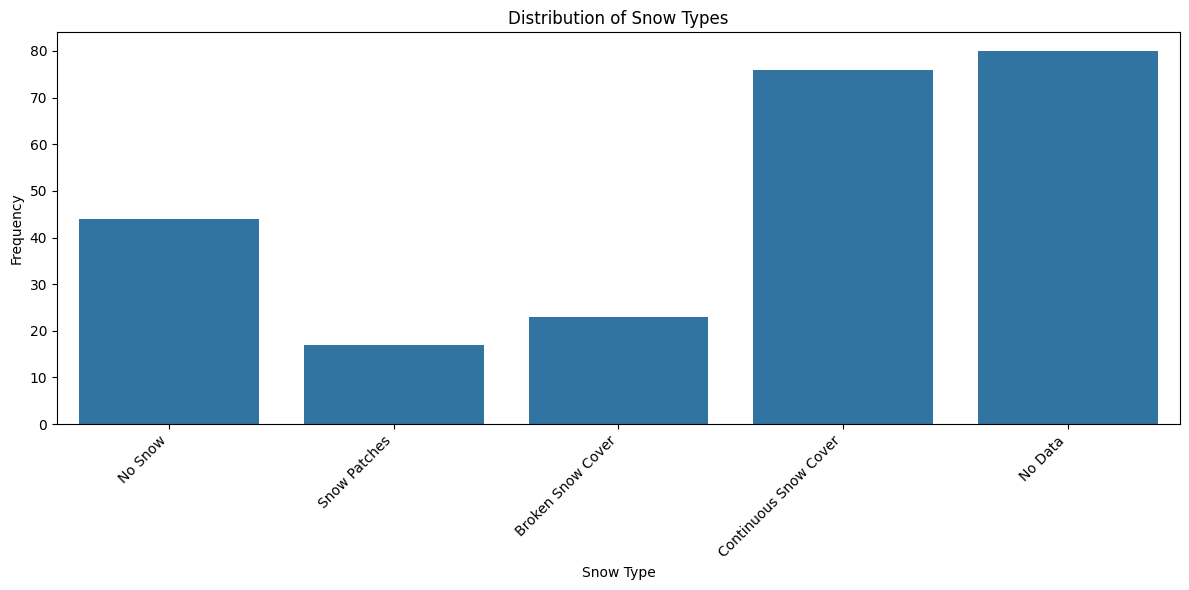

In [810]:
# Mapping for snow type codes to descriptions
snow_type_mapping = {
    0: 'No Snow',
    1: 'Snow Patches',
    2: 'Broken Snow Cover',
    3: 'Continuous Snow Cover',
    9: 'No Data'
}

# Replace NaN values in 'sha_manu' with a string 'NaN' temporarily for plotting
data_cleaned['sha_manu_plot'] = data_cleaned['sha_manu'].fillna(9)

# Plotting the distribution of snow types
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='sha_manu_plot', data=data_cleaned)
ax.set_xticklabels([snow_type_mapping[int(float(label.get_text()))] for label in ax.get_xticklabels()])

plt.xlabel("Snow Type")
plt.ylabel("Frequency")
plt.title("Distribution of Snow Types")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Remove the temporary column after plotting
data_cleaned.drop(columns=['sha_manu_plot'], inplace=True)


We will also simplify this feature:

In [811]:
data_cleaned['is_snowy'] = data_cleaned['sha_manu'].apply(lambda x: 1 if x in [1, 2, 3] else 0 if x == 0 else np.nan)

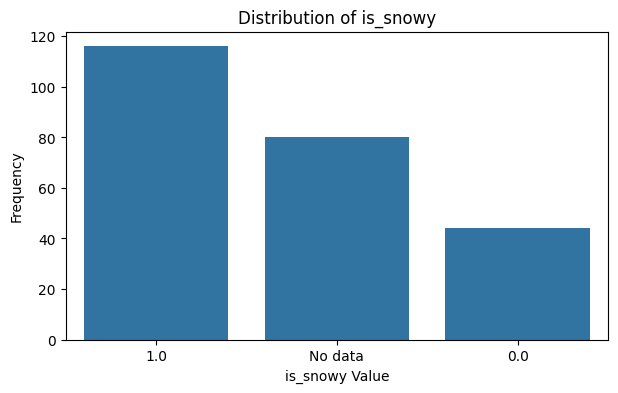

In [812]:
# Replace NaN values in 'is_snowy' with a temporary label for plotting
data_cleaned['is_snowy_plot'] = data_cleaned['is_snowy'].fillna('No data')

# Create the plot
plt.figure(figsize=(7, 4))
sns.countplot(x='is_snowy_plot', data=data_cleaned)
plt.title('Distribution of is_snowy')
plt.xlabel('is_snowy Value')
plt.ylabel('Frequency')
plt.show()

# Remove the temporary column after plotting
data_cleaned.drop(columns=['is_snowy_plot'], inplace=True)

In [813]:
data_cleaned = data_cleaned.drop(['sha_manu'], axis=1)

## Numerical Features

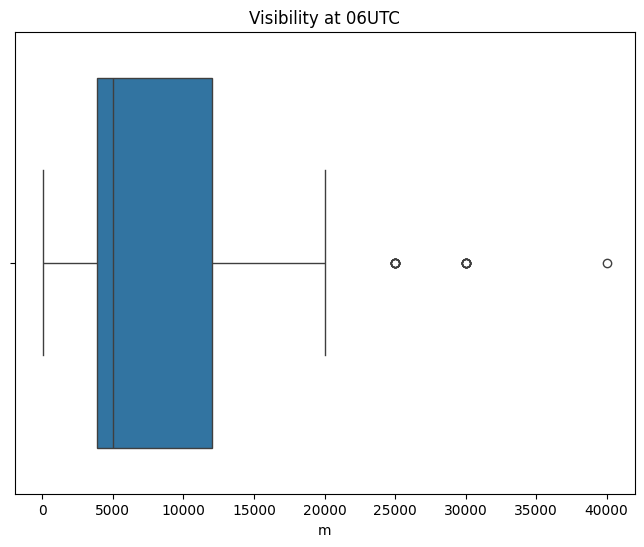

In [814]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='sicht_i', data=data_cleaned)
plt.title('Visibility at 06UTC')
plt.xlabel('m')
plt.show()

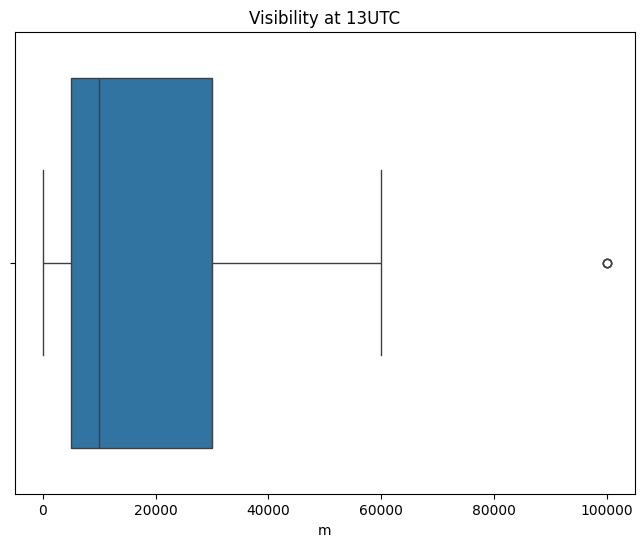

In [815]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='sicht_ii', data=data_cleaned)
plt.title('Visibility at 13UTC')
plt.xlabel('m')
plt.show()

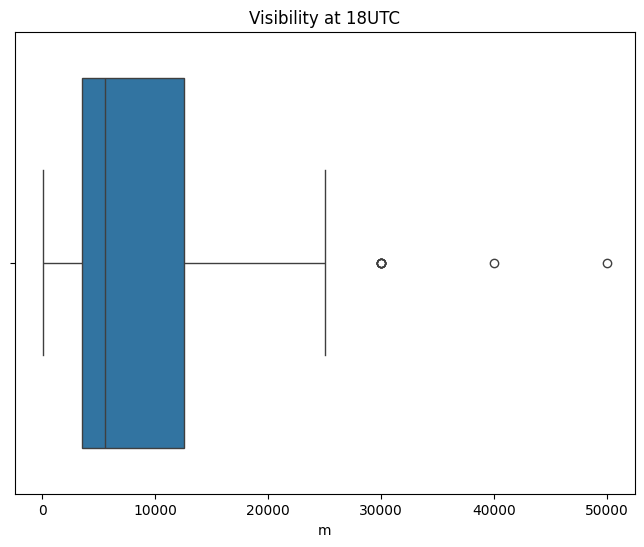

In [816]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='sicht_iii', data=data_cleaned)
plt.title('Visibility at 18UTC')
plt.xlabel('m')
plt.show()

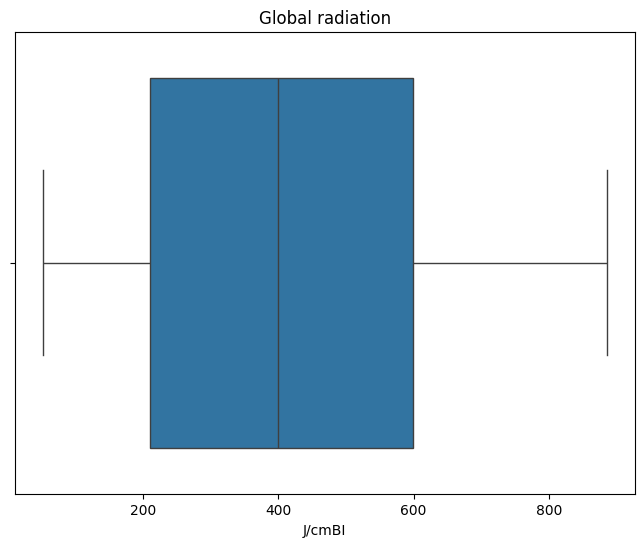

In [817]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='cglo_j', data=data_cleaned)
plt.title('Global radiation')
plt.xlabel('J/cmВІ')
plt.show()

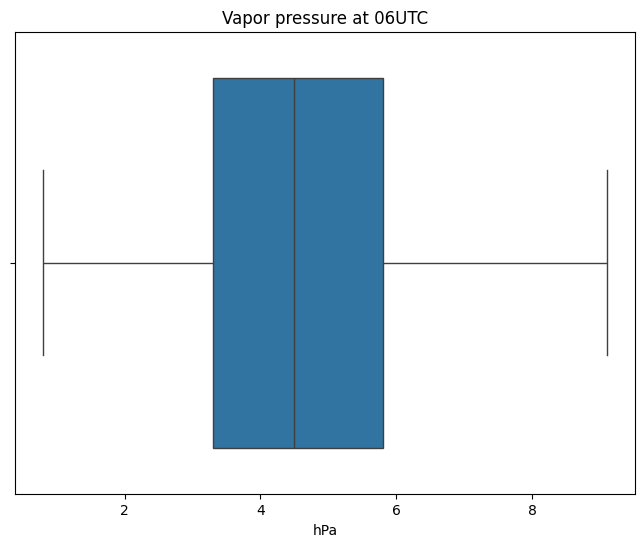

In [818]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='dampf_i', data=data_cleaned)
plt.title('Vapor pressure at 06UTC')
plt.xlabel('hPa')
plt.show()

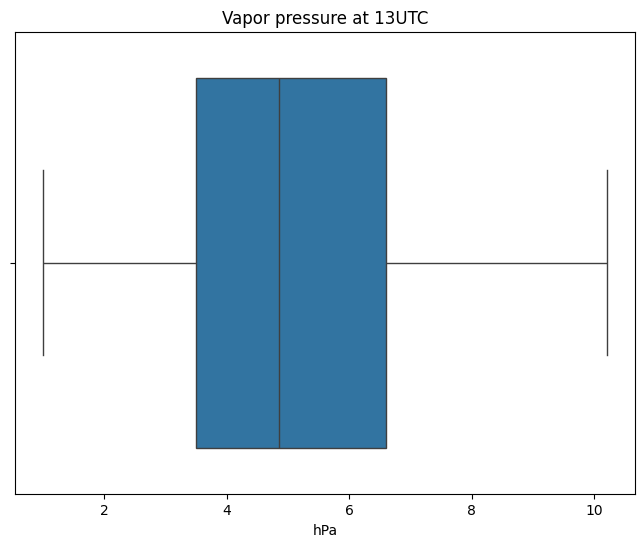

In [819]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='dampf_ii', data=data_cleaned)
plt.title('Vapor pressure at 13UTC')
plt.xlabel('hPa')
plt.show()

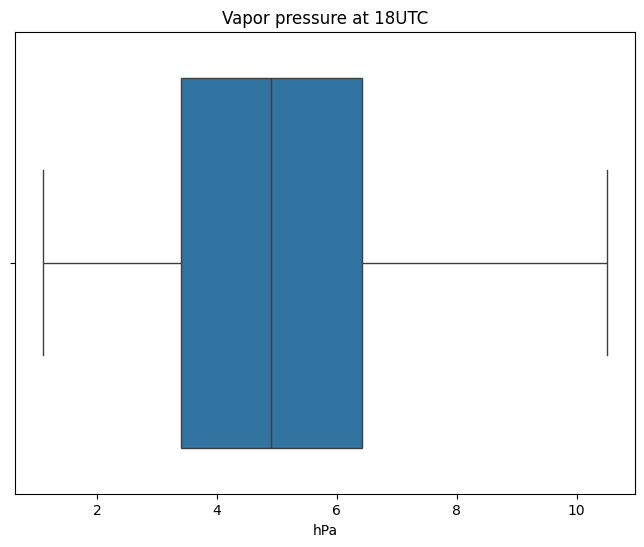

In [820]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='dampf_iii', data=data_cleaned)
plt.title('Vapor pressure at 18UTC')
plt.xlabel('hPa')
plt.show()

# Feature Summary

## Indicators

| **Feature**   | **Description**                                 | **Unique Values** | **Action**                             |
|---------------|-------------------------------------------------|-------------------|----------------------------------------|
| bft6          | Storm Indicator                                | 0, 1, NaN         | Imput missing values        |
| bft8          | Severe Storm Indicator                         | 0, NaN            | Drop        |
| gew           | Thunderstorm Indicator                         | 0, 1, NaN         | Imput missing values        |
| glatt         | Black Ice Indicator                            | 0, 1, NaN         | Imput missing values        |
| nebel         | Fog Indicator                                  | 0, 1, NaN         | Imput missing values        |
| raureif       | Hoarfrost Indicator                            | 0, 1, NaN         | Imput missing values        |
| reif          | Frost Indicator                                | 0, 1, NaN         | Imput missing values        |
| tau           | Dew Indicator                                  | 0, 1, NaN         | Imput missing values        |

---

## Aggregated

| **Feature**   | **Description**                                 | **Unique Values** | **Action**                             |
|---------------|-------------------------------------------------|-------------------|----------------------------------------|
| bewd_mittel   | Mean Cloud Density                              | [0-100], NaN      | Drop (aggregation)      |
| bewm_mittel   | Mean Cloud Cover                                | [0-100], NaN      | Drop (aggregation)      |
| dampf_mittel  | Mean Vapor Pressure                             | Continuous, NaN   | Drop (aggregation)            |
| p_mittel      | Mean Air Pressure                               | Continuous, NaN   | Drop (aggregation)            |
| rf_mittel     | Mean Relative Humidity                          | [0-100], NaN      | Drop (aggregation)            |

---

## Cyclic

| **Feature**   | **Description**                                 | **Unique Values** | **Action**                             |
|---------------|-------------------------------------------------|-------------------|----------------------------------------|
| dd32_i        | Wind Direction at Observation Time I (Cyclic)   | [0-32], NaN       | Encode cyclically    |
| dd32_ii       | Wind Direction at Observation Time II (Cyclic)  | [0-32], NaN       | Encode cyclically    |
| dd32_iii      | Wind Direction at Observation Time III (Cyclic) | [0-32], NaN       | Encode cyclically    |

---

## Nominal

| **Feature**   | **Description**                                 | **Unique Values**          | **Action**                             |
|---------------|-------------------------------------------------|----------------------------|----------------------------------------|
| rra_manu_i    | Precipitation Type at Observation Time I        | Categories' codes                | Transform to regen_i    |
| erdb_i, erdb_ii, erdb_iii        | Soil Condition at Observation Time I, II, III            | Categories' codes                | Imput missing values    |
| sha_manu      | Snow Type, calculated from Soil Condition       | Categories' codes                | Transform to is_snowy    |
| rra_manu_iii  | Precipitation Type at Observation Time III      | Categories' codes                | Transform to regen_ii    |

---

## Numerical

| **Feature**   | **Description**                                 | **Unique Values**          | **Action**                             |
|---------------|-------------------------------------------------|----------------------------|----------------------------------------|
| sicht_i, sicht_ii, sicht_iii       | Visibility at Observation Time I, II, III                | Continuous, NaN            | Imput missing values            |
| ffx           | Maximum Wind Speed                      | Continuous, NaN            | Imput missing values            |
| dampf_i, dampf_ii, dampf_iii       | Vapor Pressure at Observation Time I, II, III            | Continuous, NaN            | Imput missing values            |
| p_i, p_ii, p_iii           | Air Pressure at Observation Time I, II, III              | Continuous, NaN            | Imput missing values            |
| rf_i, rf_ii, rf_iii          | Relative Humidity at Observation Time I, II, III         | [0-100], NaN               | Imput missing values            |
| cglo_j | Global radiation | Continuous, NaN | Imput missing values            |
| rr_i, rr_ii | Precipitation 12h total for observation date I, II | Continuous, NaN | Imput missing values            |
| sh_manu | Total snow depth, manual measurement | Continuous, NaN | Imput missing values            |
| shneu_manu | New snow depth, manual measurement | Continuous, NaN | Imput missing values            |
| so_h | Duration of sunshine | Continuous, NaN | Imput missing values            |

---

## Ordinal

| **Feature**   | **Description**                                 | **Unique Values**          | **Action**                             |
|---------------|-------------------------------------------------|----------------------------|----------------------------------------|
| bewd_i, bewd_ii, bewd_iii        | Cloud Density at Observation Time I, II, III             | [0, 1, 2], NaN             | Imput missing values      |
| bewm_i, bewm_ii, bewm_iii        | Cloud Cover at Observation Time I, II, III               | [0-10], NaN                | Imput missing values      |
| vvbft_i, vvbft_ii, vvbft_iii | Wind strength at observation date I, II, III | [0-12] | Imput missing values      |


## Split the dataset
### Target features

In [827]:
Y = data_cleaned[['tlmax', 'tlmin', 'tl_mittel']]
print(Y)

     tlmax  tlmin  tl_mittel
0     -4.8   -7.6       -6.2
1     -1.0   -6.4       -3.7
2     -2.5   -8.9       -5.7
3     -4.2   -6.4       -5.3
4     -4.8   -6.9       -5.9
..     ...    ...        ...
235   15.1    6.2       10.7
236    9.8   -4.1        2.9
237   10.7    0.8        5.8
238    9.3   -0.9        4.2
239   13.8    7.0       10.4

[240 rows x 3 columns]


### Input features

In [828]:
print(data_cleaned.shape)

missing_percentage = data_cleaned.isnull().sum() / len(data_cleaned) * 100

# Identify columns with more than 10% missing values
columns_to_drop = missing_percentage[missing_percentage > 10].index
print('Columns to drop:', columns_to_drop)

(240, 61)
Columns to drop: Index(['bewd_i', 'bewd_ii', 'bewd_iii', 'bewm_i', 'bewm_ii', 'bewm_iii',
       'bft6', 'cglo_j', 'erdb_i', 'erdb_ii', 'erdb_iii', 'gew', 'glatt',
       'nebel', 'raureif', 'reif', 'sh_manu', 'shneu_manu', 'sicht_i',
       'sicht_ii', 'sicht_iii', 'tau', 'tsmin', 'is_snowy'],
      dtype='object')


In [830]:
X = data_cleaned.drop(columns=Y)
X = X.drop(columns=columns_to_drop)
print(X.columns)

Index(['date', 'id', 'dampf_i', 'dampf_ii', 'dampf_iii', 'dd32_i', 'dd32_ii',
       'dd32_iii', 'ffx', 'p_i', 'p_ii', 'p_iii', 'rf_i', 'rf_ii', 'rf_iii',
       'rr_i', 'rr_iii', 'so_h', 'tl_i', 'tl_ii', 'tl_iii', 'vvbft_i',
       'vvbft_ii', 'vvbft_iii', 'zeitx', 'substation', 'year', 'month', 'day',
       'lat', 'lon', 'name', 'regen_i', 'regen_ii'],
      dtype='object')


In [831]:
X = X. drop(['date', 'tl_i', 'tl_ii', 'tl_iii', 'zeitx', 'substation', 'name'], axis = 1)
X

,id,dampf_i,dampf_ii,dampf_iii,dd32_i,dd32_ii,dd32_iii,ffx,p_i,p_ii,...,vvbft_i,vvbft_ii,vvbft_iii,year,month,day,lat,lon,regen_i,regen_ii
0,8,3.2,3.2,3.0,12.0,20.0,16.0,7.3,971.4,967.9,...,2.0,1.0,1.0,2016,1,4,46.872220,15.903610,0,0
1,66,3.7,3.5,4.0,0.0,20.0,0.0,7.1,783.1,782.5,...,0.0,1.0,0.0,2016,1,4,46.866940,11.024440,0,0
2,68,3.1,4.6,3.8,12.0,28.0,28.0,12.1,802.9,802.3,...,4.0,1.0,3.0,2016,1,4,47.248890,13.559720,0,0
3,93,3.3,3.5,3.3,32.0,32.0,32.0,8.3,965.9,965.3,...,2.0,2.0,1.0,2016,1,4,48.199720,15.631110,0,0
4,27,3.8,4.2,4.2,12.0,12.0,12.0,9.2,NaN,NaN,...,2.0,2.0,1.0,2016,1,4,48.204220,13.825000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,37,7.7,9.7,8.2,20.0,24.0,4.0,15.8,989.6,992.0,...,2.0,5.0,2.0,2016,1,28,48.603330,16.061670,0,0
236,20,4.1,5.8,6.2,0.0,4.0,0.0,4.5,911.5,911.2,...,0.0,1.0,0.0,2016,1,28,47.404170,10.920000,0,0
237,71,5.8,6.5,6.1,16.0,20.0,8.0,4.3,904.5,904.8,...,1.0,2.0,2.0,2016,1,28,46.938333,14.920278,0,0
238,43,3.8,4.2,4.4,0.0,0.0,4.0,3.8,871.4,870.9,...,0.0,0.0,1.0,2016,1,28,47.004780,12.646500,0,0


In [832]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Handling missing values

In [833]:
print(X_train.isnull().sum())

id           0
dampf_i      0
dampf_ii     0
dampf_iii    0
dd32_i       7
dd32_ii      7
dd32_iii     7
ffx          8
p_i          8
p_ii         8
p_iii        8
rf_i         0
rf_ii        0
rf_iii       0
rr_i         0
rr_iii       0
so_h         0
vvbft_i      7
vvbft_ii     7
vvbft_iii    7
year         0
month        0
day          0
lat          0
lon          0
regen_i      0
regen_ii     0
dtype: int64


In [834]:
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

### Baseline Model

In [835]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [836]:
# Predict on the test set
Y_pred = rf_model.predict(X_test)

### Evaluation

In [839]:
# Calculate RMSE, MAE, and Bias
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
mae = mean_absolute_error(Y_test, Y_pred)
bias = np.mean(Y_pred - Y_test)

print("Evaluation Metrics:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Bias: {bias}")

Evaluation Metrics:
RMSE: 1.9797024993950763
MAE: 1.5163750000000003
Bias: -0.362583333333334


In [840]:
# Correlation
correlation = np.corrcoef(Y_test.values.ravel(), Y_pred.ravel())[0, 1]
print(f"Correlation: {correlation}")

Correlation: 0.9563655718674371


<ipython-input-841-15c48e29b066>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(Y_test[col], label='Ground Truth', color='blue', shade=True)
<ipython-input-841-15c48e29b066>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(Y_pred[:, Y_test.columns.get_loc(col)], label='Prediction', color='orange', shade=True)


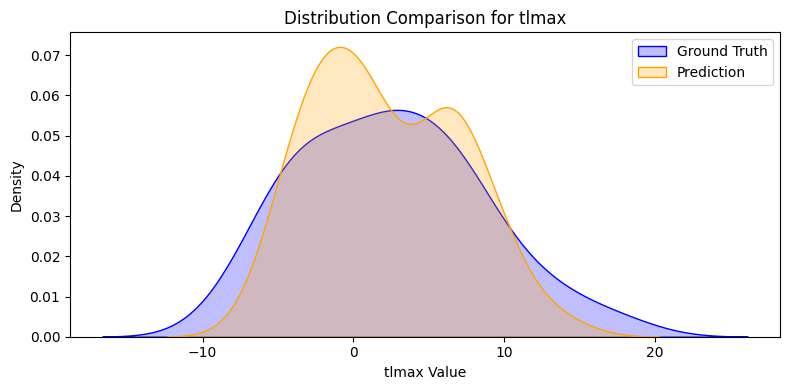

<ipython-input-841-15c48e29b066>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(Y_test[col], label='Ground Truth', color='blue', shade=True)
<ipython-input-841-15c48e29b066>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(Y_pred[:, Y_test.columns.get_loc(col)], label='Prediction', color='orange', shade=True)


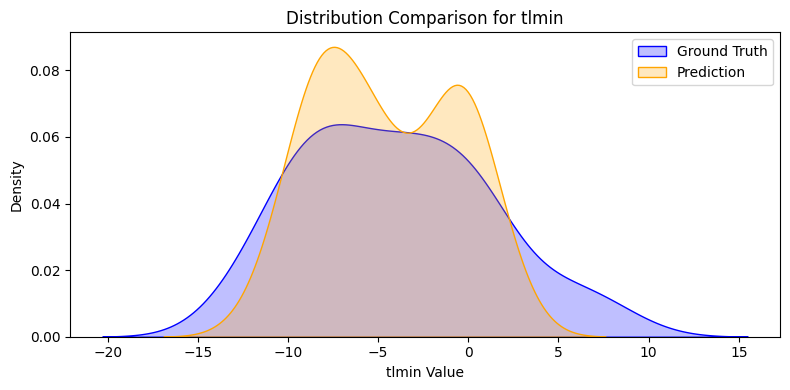

<ipython-input-841-15c48e29b066>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(Y_test[col], label='Ground Truth', color='blue', shade=True)
<ipython-input-841-15c48e29b066>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(Y_pred[:, Y_test.columns.get_loc(col)], label='Prediction', color='orange', shade=True)


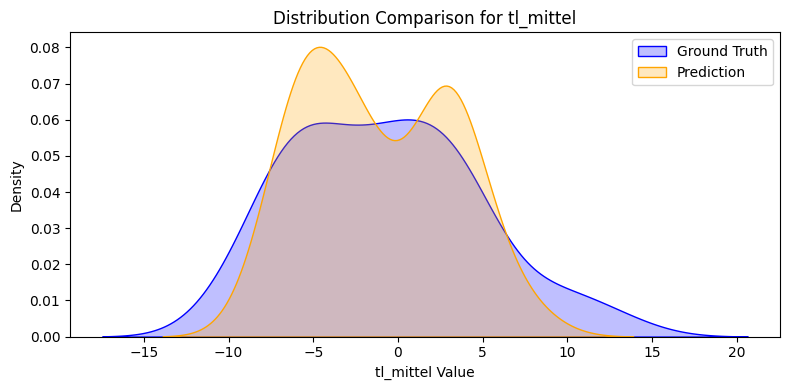

In [841]:
# Distribution Plots
for col in Y_test.columns:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(Y_test[col], label='Ground Truth', color='blue', shade=True)
    sns.kdeplot(Y_pred[:, Y_test.columns.get_loc(col)], label='Prediction', color='orange', shade=True)
    plt.title(f"Distribution Comparison for {col}")
    plt.xlabel(f"{col} Value")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

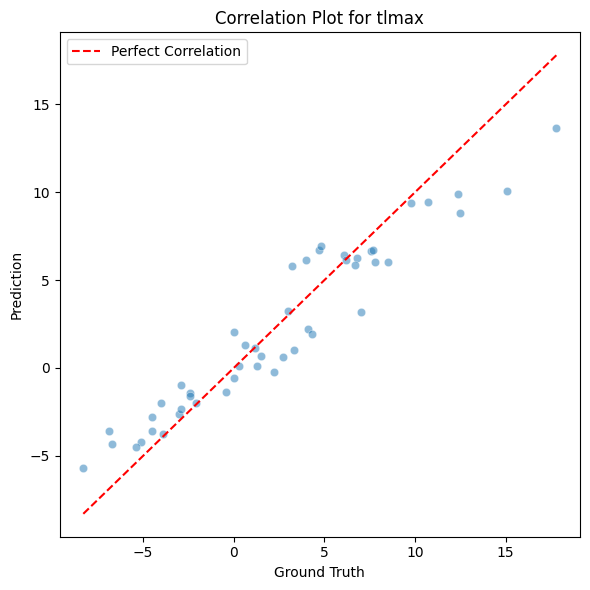

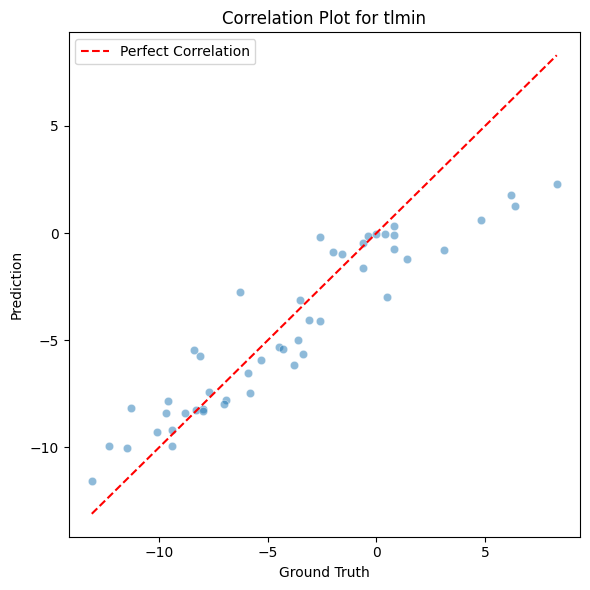

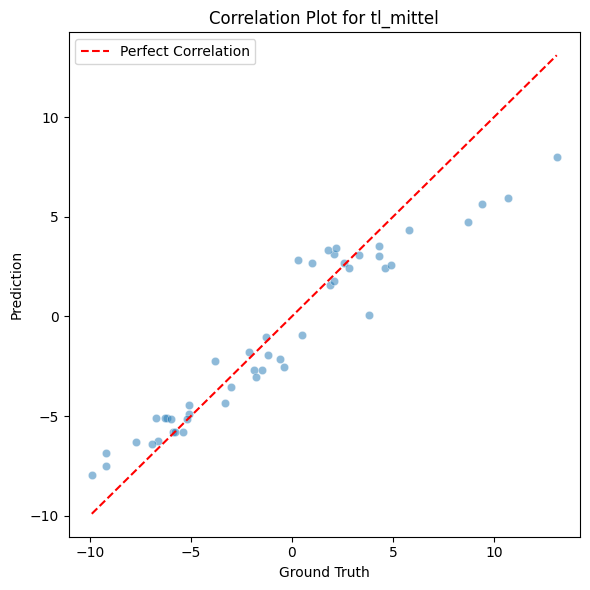

In [842]:
# Correlation Plot
for col in Y_test.columns:
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=Y_test[col], y=Y_pred[:, Y_test.columns.get_loc(col)], alpha=0.5)
    plt.plot([Y_test[col].min(), Y_test[col].max()],
             [Y_test[col].min(), Y_test[col].max()], color='red', linestyle='--', label='Perfect Correlation')
    plt.title(f"Correlation Plot for {col}")
    plt.xlabel("Ground Truth")
    plt.ylabel("Prediction")
    plt.legend()
    plt.tight_layout()
    plt.show()

## AutoML

In [849]:
Y1 = data_cleaned['tlmax']
Y2 = data_cleaned['tlmin']
Y3 = data_cleaned['tl_mittel']

In [851]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X, Y1, test_size=0.2, random_state=42)

In [852]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models, predictions = reg.fit(X_train_1, X_test_1, Y_train_1, Y_test_1)

 21%|██▏       | 9/42 [00:00<00:03,  8.94it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 74%|███████▍  | 31/42 [00:02<00:00, 18.72it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


100%|██████████| 42/42 [00:03<00:00, 13.08it/s]

XGBRegressor model failed to execute
'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 718
[LightGBM] [Info] Number of data points in the train set: 192, number of used features: 25
[LightGBM] [Info] Start training from score 2.545833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

## Imput the same as nearest station (computationally expensive)

In [557]:
# from geopy.distance import geodesic
# from sklearn.impute import KNNImputer

# station_coords = data_cleaned[['id', 'lat', 'lon', 'name']].drop_duplicates()

# # Function to calculate distances between stations
# def calculate_distance_matrix(station_coords):
#     stations = station_coords['id'].tolist()
#     n = len(stations)
#     distance_matrix = np.zeros((n, n))

#     for i in range(n):
#         for j in range(n):
#             if i != j:
#                 coord1 = (station_coords.iloc[i]['lat'], station_coords.iloc[i]['lon'])
#                 coord2 = (station_coords.iloc[j]['lat'], station_coords.iloc[j]['lon'])
#                 distance_matrix[i, j] = geodesic(coord1, coord2).km
#             else:
#                 distance_matrix[i, j] = 0  # Distance to itself is 0
#     return pd.DataFrame(distance_matrix, index=stations, columns=stations)

# # Calculate the distance matrix
# distance_matrix = calculate_distance_matrix(station_coords)

# # Normalize distances to weights (closer stations get higher weight)
# distance_weights = 1 / (distance_matrix + 1e-6)  # Add a small value to avoid division by zero

# # Function to impute missing values using distance weights
# def distance_weighted_imputation(data, distance_weights):
#     imputed_data = data.copy()
#     for column in data.columns:
#         for idx, row in imputed_data.iterrows():
#             if pd.isnull(row[column]):
#                 station = row['id']
#                 nearby_stations = distance_weights[station].sort_values(ascending=False).index
#                 valid_values = []
#                 weights = []

#                 # Collect values and weights from nearby stations
#                 for nearby_station in nearby_stations:
#                     value = imputed_data.loc[
#                         (imputed_data['id'] == nearby_station), column
#                     ].dropna()
#                     if not value.empty:
#                         valid_values.append(value.values[0])
#                         weights.append(distance_weights.loc[station, nearby_station])

#                 # Impute with weighted average
#                 if valid_values:
#                     imputed_value = np.average(valid_values, weights=weights)
#                     imputed_data.loc[idx, column] = imputed_value

#     return imputed_data

# # Perform distance-weighted imputation
# imputed_data = distance_weighted_imputation(data_cleaned, distance_weights)

# # Display the imputed data
# print(imputed_data)


                         date    bewd_i   bewd_ii  bewd_iii     bewm_i  \
0   2016-01-04 00:00:00+00:00  2.000000  2.000000  2.000000  10.000000   
1   2016-01-04 00:00:00+00:00  1.000000  1.000000  2.000000   9.000000   
2   2016-01-04 00:00:00+00:00  2.000000  2.000000  1.000000  10.000000   
3   2016-01-04 00:00:00+00:00  2.000000  2.000000  2.000000  10.000000   
4   2016-01-04 00:00:00+00:00  1.934750  1.807446  1.857138   9.669274   
..                        ...       ...       ...       ...        ...   
235 2016-01-28 00:00:00+00:00  1.000000  1.000000  2.000000  10.000000   
236 2016-01-28 00:00:00+00:00  1.822896  1.689186  1.858647   9.670902   
237 2016-01-28 00:00:00+00:00  1.000000  0.000000  0.000000   3.000000   
238 2016-01-28 00:00:00+00:00  1.919153  1.733465  1.790954   9.772404   
239 2016-01-28 00:00:00+00:00  1.878308  1.766267  1.883569   9.749263   

       bewm_ii   bewm_iii      bft6      cglo_j  dampf_i  ...  year  month  \
0    10.000000  10.000000  0.0000

In [560]:
# from geopy.distance import geodesic
# import numpy as np
# import pandas as pd

# # Function to calculate the distance matrix
# def calculate_distance_matrix(station_coords):
#     stations = station_coords['id'].tolist()
#     n = len(stations)
#     distance_matrix = np.zeros((n, n))

#     for i in range(n):
#         for j in range(n):
#             if i != j:
#                 coord1 = (station_coords.iloc[i]['lat'], station_coords.iloc[i]['lon'])
#                 coord2 = (station_coords.iloc[j]['lat'], station_coords.iloc[j]['lon'])
#                 distance_matrix[i, j] = geodesic(coord1, coord2).km
#             else:
#                 distance_matrix[i, j] = 0  # Distance to itself is 0
#     return pd.DataFrame(distance_matrix, index=stations, columns=stations)

# # Normalize distances to weights
# def normalize_distance_weights(distance_matrix):
#     return 1 / (distance_matrix + 1e-6)  # Add a small value to avoid division by zero

# # Function for spatiotemporal imputation
# def spatiotemporal_imputation(data, distance_weights):
#     """
#     Impute missing values based on nearby stations and the same day.

#     Parameters:
#         data (pd.DataFrame): The dataset to impute, must contain 'id' and 'date' columns.
#         distance_weights (pd.DataFrame): Distance-based weights between stations.

#     Returns:
#         pd.DataFrame: Imputed dataset.
#     """
#     imputed_data = data.copy()

#     for column in data.columns:
#         if column not in ['id', 'date']:  # Skip non-data columns
#             for idx, row in imputed_data.iterrows():
#                 if pd.isnull(row[column]):
#                     station = row['id']
#                     date = row['date']

#                     # Filter rows with the same date
#                     same_day_data = imputed_data[imputed_data['date'] == date]

#                     # Get nearby stations and their data
#                     nearby_stations = distance_weights[station].sort_values(ascending=False).index
#                     valid_values = []
#                     weights = []

#                     for nearby_station in nearby_stations:
#                         value = same_day_data.loc[
#                             (same_day_data['id'] == nearby_station), column
#                         ].dropna()

#                         if not value.empty:
#                             valid_values.append(value.values[0])
#                             weights.append(distance_weights.loc[station, nearby_station])

#                     # Impute with weighted average if valid values exist
#                     if valid_values:
#                         imputed_value = np.average(valid_values, weights=weights)
#                         imputed_data.loc[idx, column] = imputed_value

#     return imputed_data

# # Example Usage:
# # Assuming `data_cleaned` contains columns ['id', 'lat', 'lon', 'name', 'date', ...]
# station_coords = data_cleaned[['id', 'lat', 'lon', 'name']].drop_duplicates()

# # Calculate distance matrix
# distance_matrix = calculate_distance_matrix(station_coords)

# # Normalize weights
# distance_weights = normalize_distance_weights(distance_matrix)

# # Perform spatiotemporal imputation
# imputed_data = spatiotemporal_imputation(data_cleaned, distance_weights)

# # Display the imputed dataset
# print(imputed_data)


                         date    bewd_i   bewd_ii  bewd_iii     bewm_i  \
0   2016-01-04 00:00:00+00:00  2.000000  2.000000  2.000000  10.000000   
1   2016-01-04 00:00:00+00:00  1.000000  1.000000  2.000000   9.000000   
2   2016-01-04 00:00:00+00:00  2.000000  2.000000  1.000000  10.000000   
3   2016-01-04 00:00:00+00:00  2.000000  2.000000  2.000000  10.000000   
4   2016-01-04 00:00:00+00:00  1.934750  1.807446  1.852161   9.669274   
..                        ...       ...       ...       ...        ...   
235 2016-01-28 00:00:00+00:00  1.000000  1.000000  2.000000  10.000000   
236 2016-01-28 00:00:00+00:00  0.605667  0.645226  0.917571   4.268124   
237 2016-01-28 00:00:00+00:00  1.000000  0.000000  0.000000   3.000000   
238 2016-01-28 00:00:00+00:00  0.594272  0.604260  0.891483   4.108042   
239 2016-01-28 00:00:00+00:00  0.703219  0.735432  1.148119   4.152107   

       bewm_ii   bewm_iii      bft6      cglo_j  dampf_i  ...  year  month  \
0    10.000000  10.000000  0.0000

## Drop all column with missing values >20% (loss of information)

In [ ]:
# columns_with_missing_values_more_than_5 = columns_with_missing_values[missing_values_per < 20][missing_values_per > 5]

# # Step 1: Filter `parameter_data` to include only parameters with missing values
# # Extract the parameter names from `columns_with_missing_values_more_than_20`
# parameter_names = columns_with_missing_values_more_than_5.index

# # Filter `parameter_data` based on these parameter names
# parameters_with_missing = parameters_data[parameters_data['Parameterkürzel'].isin(parameter_names)]

# # Step 2: Merge the missing percentages with the explanations
# # Create a DataFrame for the missing percentages
# missing_df = columns_with_missing_values_more_than_5.reset_index()
# missing_df.columns = ['Parameterkürzel', 'Missing Percentage']

# # Merge the two DataFrames on the `Parameterkürzel` column
# merged_data = pd.merge(missing_df, parameters_with_missing, on='Parameterkürzel', how='inner')

# # Step 3: Print the result
# print("Parameters with Missing Values > 5%:")
# print(merged_data[['Beschreibung', 'Missing Percentage']])

In [ ]:
# columns_with_missing_values_less_than_5 = columns_with_missing_values[missing_values_per < 5]
# # Step 1: Filter `parameter_data` to include only parameters with missing values
# # Extract the parameter names from `columns_with_missing_values_more_than_20`
# parameter_names = columns_with_missing_values_less_than_5.index

# # Filter `parameter_data` based on these parameter names
# parameters_with_missing = parameters_data[parameters_data['Parameterkürzel'].isin(parameter_names)]

# # Step 2: Merge the missing percentages with the explanations
# # Create a DataFrame for the missing percentages
# missing_df = columns_with_missing_values_less_than_5.reset_index()
# missing_df.columns = ['Parameterkürzel', 'Missing Percentage']

# # Merge the two DataFrames on the `Parameterkürzel` column
# merged_data = pd.merge(missing_df, parameters_with_missing, on='Parameterkürzel', how='inner')

# # Step 3: Print the result
# print("Parameters with Missing Values < 5%:")
# print(merged_data[['Beschreibung', 'Missing Percentage']])

## Split the dataset

In [630]:
data_cleaned.columns

Index(['date', 'id', 'bewd_i', 'bewd_ii', 'bewd_iii', 'bewm_i', 'bewm_ii',
       'bewm_iii', 'bft6', 'cglo_j', 'dampf_i', 'dampf_ii', 'dampf_iii',
       'dd32_i', 'dd32_ii', 'dd32_iii', 'erdb_i', 'erdb_ii', 'erdb_iii', 'ffx',
       'gew', 'glatt', 'nebel', 'p_i', 'p_ii', 'p_iii', 'raureif', 'reif',
       'rf_i', 'rf_ii', 'rf_iii', 'rr_i', 'rr_iii', 'sh_manu', 'shneu_manu',
       'sicht_i', 'sicht_ii', 'sicht_iii', 'so_h', 'tau', 'tl_i', 'tl_ii',
       'tl_iii', 'tlmax', 'tlmin', 'tl_mittel', 'tsmin', 'vvbft_i', 'vvbft_ii',
       'vvbft_iii', 'zeitx', 'substation', 'year', 'month', 'day', 'lat',
       'lon', 'name', 'regen_i', 'regen_ii', 'is_snowy'],
      dtype='object')

In [631]:
data_cleaned.shape

(240, 61)

In [ ]:
X = data_cleaned['id', 'tlmax', 'tlmin', 'tl_mittel', 'date']

In [ ]:
X.shape

In [ ]:
print(X.dtypes)

In [ ]:
correlation_matrix = X.drop(['time'], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
numerical_columns = imputed_data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = imputed_data.select_dtypes(include=['object']).columns
numerical_data = imputed_data[numerical_columns]
categorical_data = imputed_data[categorical_columns]
print("Numerical Data:")
print(numerical_data.shape)

print("\nCategorical Data:")
print(categorical_data.shape)

## Feature Selection

### Low variance

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Set a threshold for variance (e.g., 0.01)
selector = VarianceThreshold(threshold=0.01)
reduced_data = selector.fit_transform(numerical_data)

# Check remaining features
selected_features = numerical_data.columns[selector.get_support()]
print(selected_features.shape[0],"selected Features:", selected_features.values)

In [ ]:
numerical_data = numerical_data[selected_features]
numerical_data.shape

### Highly correlated features

In [ ]:
# Compute correlation matrix
correlation_matrix = numerical_data.corr().abs()

# Select upper triangle of the correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.9
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop highly correlated features
numerical_data = numerical_data.drop(columns=to_drop)
print(f"Features dropped due to high correlation: {to_drop}")


In [ ]:
numerical_data.shape

In [ ]:
quality_flag_columns = [col for col in numerical_data.columns if 'flag' in col]
print(quality_flag_columns)